# Goal of this workshop
The goal of this workshop is to give you a thourough understanding of Tensorflow and how you can use it to effectively build and train neural network models.

We will not be running big models since we have limited time and hardware, but hopefully this will give you the skills and tools to go home later and confidently start running different experiments.

Lets start by importing some standard libraries:

In [40]:
import sys, os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)
%matplotlib inline

__take a moment to review numpy and talk about how operations are element-wise, etc__

In [2]:
tf.reset_default_graph()

In [3]:
x = tf.placeholder(tf.float32, shape=[], name="x")
y = x + 2

session = tf.Session()

result = session.run(y, feed_dict={x: 3})
print(result)

5.0


Since both y and x are nodes in the graph, we can "ask" for both of them in the output of session.run (this does not run the graph twice!):

In [4]:
result = session.run([y, x], feed_dict={x: 5})
print("y = {}".format(result[0]))
print("x = {}".format(result[1]))

y = 7.0
x = 5.0


Now let's say we want a linear model, so we have some input $x$ and the output is given by $y = x^T w + b$. Let's put that into a function called _linear_, which receives an input $x$ and weights $w$ and bias $b$ and returns $y$. Make the input $x$ a 3-dimensional vector and use a constant variable $w$ and $b$ by using tf.constant(value).

Given info:
    remember that $x^T w = \sum_i x_i \cdot w_i$

In [5]:
def linear(inp, weights, bias):
    return tf.reduce_sum(tf.multiply(weights, inp)) + bias

x = tf.placeholder(tf.float32, shape=[3], name="x")
w = tf.constant(np.array([1.,1.,1.], dtype=np.float32), name="w")
b = tf.constant(0.0, name="b")
y = linear(x, w, b)

session = tf.Session()

result = session.run(y, feed_dict={x: np.array([1.,2.,3.])})
print("y = {}".format(result))

y = 6.0


Ok so at this point we have a function that can take one input and return its output according to a simple linear model. However, we usually want to pass many inputs at the same time (this is what we call a batch), and get all the outputs. So let's change our placeholder in order for it to accept 4 input vectors (lets make x a 4x3 placeholder). Remember we now want our output to have 4 elements, one for each input array.
__depict this batch multiplication, and show that we need to ue axis=1 in the reduce_sum__

In [6]:
def linear(inp, weights, bias):
    return tf.reduce_sum(tf.multiply(weights, inp), axis=1) + bias

x = tf.placeholder(tf.float32, shape=[4, 3], name="x")
w = tf.constant(np.array([1.,1.,1.], dtype=np.float32), name="w")
b = tf.constant(0.0, name="b")
y = linear(x, w, b)

session = tf.Session()

result = session.run(y, feed_dict={x: np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12]])})
print("y = {}".format(result))

y = [  6.  15.  24.  33.]


Furthermore, we also want the outputs to have higher dimension than 1, so let's make our outputs are 2 dimensional. This means that now $w$ is not a vector but a input_dim x out_dim matrix, so 3x2 in this case, and $b$ is a vector of length 2. So go ahead and change the matrix accordingly and check if the results are correct. Your $y$ now should be 4x2 dimensional.

Also, using tf.reduce_sum and tf.multiply is ugly and won't work in this case, so let's use what we should have been using in the first place: tf.matmul, which multiplies two matrices, which is what we want!

In [7]:
def linear(inp, weights, bias):
    return tf.matmul(inp, weights) + bias

x = tf.placeholder(tf.float32, shape=[4, 3], name="x")
w = tf.constant(np.array([[1,2],[1,2],[1,2]], dtype=np.float32), name="w")
b = tf.constant(np.array([0,0], dtype=np.float32), name="b")
y = linear(x, w, b)

session = tf.Session()

result = session.run(y, feed_dict={x: np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12]])})
print("y = {}".format(result))

y = [[  6.  12.]
 [ 15.  30.]
 [ 24.  48.]
 [ 33.  66.]]


As you can see we are heading towards a linear regression implementation here. We have a linear model, our inputs, outputs, and parameters. However, we need a few more things before we can make it learn.

First of all we need targets, right? For linear regression we have our inputs, but we also have a set of target outputs, to which the model's outputs $y$ must be close. So let's create another placeholder which will receive the target outputs and compute the squared difference between that and the model's output for each item in the batch. __I will provide some data here__ Remember target outputs are supposed to be the same shape as the model's outputs, so that we can compute their difference. Also, change session.run so that it returns the cost and not the outputs y.


In [8]:
def linear(inp, weights, bias):
    return tf.matmul(inp, weights) + bias

x = tf.placeholder(tf.float32, shape=[4, 3], name="x")
w = tf.constant(np.array([[1,2],[1,2],[1,2]], dtype=np.float32), name="w")
b = tf.constant(np.array([0,0], dtype=np.float32), name="b")
y = linear(x, w, b)

target = tf.placeholder(tf.float32, shape=[4, 2], name="target")

cost = tf.reduce_sum(tf.square(y-target), axis=1)

session = tf.Session()

feed_dict = {
    x: np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12]]),
    target: np.array([[3,6], [7.5, 15], [12, 24], [16.5, 33]])
}
result = session.run(cost, feed_dict=feed_dict)
print("cost = {}".format(result))

cost = [   45.     281.25   720.    1361.25]


Another thing we are missing we that the parameters $w$ and $b$ that we want to optimized are defined as a constant in the graph, so we can't change them! What we want is to define $w$ and $b$ as a variables instead: tf.Variable.
One thing we have to bear in mind is that unlike the constant, a Variable node has no value before it is initialized (its like being empty). So we have to run session.run(theta.initializer) before running operations that depend on it.

In [9]:
def linear(inp, weights, bias):
    return tf.matmul(inp, weights) + bias

x = tf.placeholder(tf.float32, shape=[4, 3], name="x")
w = tf.Variable(np.array([[1,2],[1,2],[1,2]], dtype=np.float32), name="w")
b = tf.Variable(np.array([0,0], dtype=np.float32), name="b")
y = linear(x, w, b)

target = tf.placeholder(tf.float32, shape=[4, 2], name="target")

cost = tf.reduce_sum(tf.square(y-target), axis=1)

session = tf.Session()
session.run(w.initializer)
session.run(b.initializer)

feed_dict = {
    x: np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12]]),
    target: np.array([[3,6], [7.5, 15], [12, 24], [16.5, 33]])
}
result = session.run(cost, feed_dict=feed_dict)
print("cost = {}".format(result))

cost = [   45.     281.25   720.    1361.25]


Great! Now we have inputs, outputs, targets, parameters and the cost. What else do we need? We need to know how to change $\theta$ in order to make the cost smaller. 
__Explain what the cost is here, and how to perform gradient descent__

Let's start by computing the gradient of the cost with respect to all our parameters, which are $w$ and $b$. Tensorflow provides a way to access all variables by calling tf.global_variables()

In [2]:
tf.reset_default_graph()
def linear(inp, weights, bias):
    return tf.matmul(inp, weights) + bias

x = tf.placeholder(tf.float32, shape=[4, 3], name="x")
w = tf.Variable(np.array([[1,2],[1,2],[1,2]], dtype=np.float32), name="w")
b = tf.Variable(np.array([0,0], dtype=np.float32), name="b")
y = linear(x, w, b)

target = tf.placeholder(tf.float32, shape=[4, 2], name="target")

cost = tf.reduce_mean(tf.reduce_sum(tf.square(y-target), axis=1))
gradients = tf.gradients(cost, tf.trainable_variables())

session = tf.Session()
session.run(w.initializer)
session.run(b.initializer)

In [3]:
feed_dict = {
    x: np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12]]),
    target: np.array([[3,6], [7.5, 15], [12, 24], [16.5, 33]])
}
result = session.run([cost, gradients], feed_dict=feed_dict)
print("cost = {}".format(result[0]))
print("gradients = {}".format(result[1]))

cost = 601.875
gradients = [array([[ 141. ,  282. ],
       [ 160.5,  321. ],
       [ 180. ,  360. ]], dtype=float32), array([ 19.5,  39. ], dtype=float32)]


Now we have to update our parameters. Since Variables are special in that their value does not depend on the input, and if we change their value we want it to remain for the next sess.run's, there are special method to update them. So, according to gradient descent we want to perform __formula__
We can change the value using tf.assign. If we wanted to change a single variable, we would do tf.assign(var, new_value), since want to update all the variables, lets use it like this instead
[tf.assign(var, var - 0.001 * grad) for var, grad in zip(tf.trainable_variables(), gradients)]
just copy it to your code.

In [9]:
tf.reset_default_graph()

def linear(inp, weights, bias):
    return tf.matmul(inp, weights) + bias

x = tf.placeholder(tf.float32, shape=[4, 3], name="x")
w = tf.Variable(np.array([[1,2],[1,2],[1,2]], dtype=np.float32), name="w")
b = tf.Variable(np.array([0,0], dtype=np.float32), name="b")
y = linear(x, w, b)

target = tf.placeholder(tf.float32, shape=[4, 2], name="target")

cost = tf.reduce_mean(tf.reduce_sum(tf.square(y-target), axis=1))
gradients = tf.gradients(cost, tf.trainable_variables())

update_op = tf.group(*[tf.assign(var, var - grad) for var, grad in zip(tf.trainable_variables(), gradients)])

session = tf.Session()
session.run(w.initializer)
session.run(b.initializer)

In [11]:
feed_dict = {
    x: np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12]]),
    target: np.array([[3,6], [7.5, 15], [12, 24], [16.5, 33]])
}
result = session.run([cost, gradients, update_op], feed_dict=feed_dict)
print("cost = {}".format(result[0]))

cost = 63474308.0


Since we don't want to press enter everytime, let's put this session.run cell into a for loop and run it for, say, 20 iterations, printing out the cost (you don't need to print the gradient).

In [12]:
tf.reset_default_graph()
def linear(inp, weights, bias):
    return tf.matmul(inp, weights) + bias

x = tf.placeholder(tf.float32, shape=[4, 3], name="x")
w = tf.Variable(np.array([[1,2],[1,2],[1,2]], dtype=np.float32), name="w")
b = tf.Variable(np.array([0,0], dtype=np.float32), name="b")
y = linear(x, w, b)

target = tf.placeholder(tf.float32, shape=[4, 2], name="target")

cost = tf.reduce_mean(tf.reduce_sum(tf.square(y-target), axis=1))
gradients = tf.gradients(cost, tf.trainable_variables())

update_op = tf.group(*[tf.assign(var, var - grad) for var, grad in zip(tf.trainable_variables(), gradients)])

session = tf.Session()
session.run(w.initializer)
session.run(b.initializer)

In [13]:
feed_dict = {
    x: np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12]]),
    target: np.array([[3,6], [7.5, 15], [12, 24], [16.5, 33]])
}

for i in range(20):
    result = session.run([cost, gradients, update_op], feed_dict=feed_dict)
    print("cost = {:.4f}".format(result[0]))

cost = 601.8750
cost = 63474308.0000
cost = 6694441582592.0000
cost = 706042320805429248.0000
cost = 74464124024010752131072.0000
cost = 7853504425729086972177154048.0000
cost = 828285176903947277824201001533440.0000
cost = inf
cost = inf
cost = inf
cost = inf
cost = inf
cost = inf
cost = inf
cost = inf
cost = inf
cost = inf
cost = nan
cost = nan
cost = nan


Oh no, our cost is going up! Does anyone know why that is happening?
__lengthy discussion about learning rate here__
We need to use a smaller learning rate, so go ahead and multiply the gradient by a small number until you find one that makes the cost go to zero. (settle for 0.001)

In [14]:
tf.reset_default_graph()
def linear(inp, weights, bias):
    return tf.matmul(inp, weights) + bias

x = tf.placeholder(tf.float32, shape=[4, 3], name="x")
w = tf.Variable(np.array([[1,2],[1,2],[1,2]], dtype=np.float32), name="w")
b = tf.Variable(np.array([0,0], dtype=np.float32), name="b")
y = linear(x, w, b)

target = tf.placeholder(tf.float32, shape=[4, 2], name="target")

cost = tf.reduce_mean(tf.reduce_sum(tf.square(y-target), axis=1))
gradients = tf.gradients(cost, tf.trainable_variables())

update_op = tf.group(*[tf.assign(var, var - 0.001 * grad) for var, grad in zip(tf.trainable_variables(), gradients)])

session = tf.Session()
session.run(w.initializer)
session.run(b.initializer)

In [15]:
feed_dict = {
    x: np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12]]),
    target: np.array([[3,6], [7.5, 15], [12, 24], [16.5, 33]])
}

for i in range(20):
    result = session.run([cost, gradients, update_op], feed_dict=feed_dict)
    print("cost = {:.4f}".format(result[0]))

cost = 601.8750
cost = 273.6334
cost = 124.4133
cost = 56.5772
cost = 25.7386
cost = 11.7193
cost = 5.3459
cost = 2.4486
cost = 1.1314
cost = 0.5325
cost = 0.2602
cost = 0.1364
cost = 0.0801
cost = 0.0544
cost = 0.0427
cost = 0.0373
cost = 0.0348
cost = 0.0337
cost = 0.0331
cost = 0.0328


So there it is, you just implemented your own linear regression in Tensorflow! Pat yourselves in the back and let's get right into using this to build neural networks.

First of all, we need a better dataset, this one is not even real! So to start off, we are going to use the Iris petal dataset __describe dataset__
This is a classification problem, and right now what we are doing is regression, so before we start using our actual dataset let's take a moment to talk about classification and logistic regression.

__lengthy discussion of logistic regression and softmax__

Ok, now that we understand how logistic regression works, lets change our code to perform classification. First, change your target outputs to these __provide targets__ and create a negative loglikelihood cost function __as formula shown__. Then add an extra argument to your linear layer called activation_fn, which will be applied to the output.

In [83]:
tf.reset_default_graph()

def negloglikelihood_cost(out, target_out):
    return -tf.reduce_sum(target_out * tf.log(out + 1e-7), axis=1)

def linear(inp, weights, bias, activation_fn):
    return activation_fn(tf.matmul(inp, weights) + bias)

x = tf.placeholder(tf.float32, shape=[4, 3], name="x")
w = tf.Variable(np.array([[1,2],[1,2],[1,2]], dtype=np.float32), name="w")
b = tf.Variable(np.array([0,0], dtype=np.float32), name="b")
y = linear(x, w, b, tf.nn.softmax)

target = tf.placeholder(tf.float32, shape=[4, 2], name="target")

cost = tf.reduce_mean(negloglikelihood_cost(y, target))
gradients = tf.gradients(cost, tf.trainable_variables())

update_op = tf.group(*[tf.assign(var, var - 0.001 * grad) for var, grad in zip(tf.trainable_variables(), gradients)])

session = tf.Session()
session.run(w.initializer)
session.run(b.initializer)

In [84]:
feed_dict = {
    x: np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12]]),
    target: np.array([[0,1], [0, 1], [1, 0], [1, 0]])
}

for i in range(20):
    result = session.run([cost, gradients, update_op], feed_dict=feed_dict)
    print("cost = {:.4f}".format(result[0]))

cost = 8.0596
cost = 8.0596
cost = 8.0596
cost = 8.0596
cost = 8.0596
cost = 8.0596
cost = 8.0596
cost = 8.0596
cost = 8.0596
cost = 8.0596
cost = 8.0596
cost = 8.0596
cost = 8.0596
cost = 8.0596
cost = 8.0596
cost = 8.0596
cost = 8.0596
cost = 8.0596
cost = 8.0596
cost = 8.0596


Ok, our cost is going down, but it is doing so kinda slowly... This highlights a very important aspect of training neural networks: initializations and dimensionality matter a lot!
__exaplain that weights should be small and inputs should be centered, or at least scaled__
So lets instead initialize the weight matrix with values 10 times smaller and also divide the input vector by 12 (let's assume 12 is the maximum value), and see how things work now.

In [85]:
tf.reset_default_graph()

def negloglikelihood_cost(out, target_out):
    return -tf.reduce_sum(target_out * tf.log(out + 1e-7), axis=1)

def linear(inp, weights, bias, activation_fn):
    return activation_fn(tf.matmul(inp, weights) + bias)

x = tf.placeholder(tf.float32, shape=[4, 3], name="x")
w = tf.Variable(np.array([[1,2],[1,2],[1,2]], dtype=np.float32)/10, name="w")
b = tf.Variable(np.array([0,0], dtype=np.float32), name="b")
y = linear(x, w, b, tf.nn.softmax)
target = tf.placeholder(tf.float32, shape=[4, 2], name="target")

cost = tf.reduce_mean(negloglikelihood_cost(y, target))
gradients = tf.gradients(cost, tf.trainable_variables())

update_op = tf.group(*[tf.assign(var, var - 0.001 * grad) for var, grad in zip(tf.trainable_variables(), gradients)])

session = tf.Session()
session.run(w.initializer)
session.run(b.initializer)

In [86]:
feed_dict = {
    x: np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12]])/12.,
    target: np.array([[0,1], [0, 1], [1, 0], [1, 0]])
}

for i in range(20):
    result = session.run([cost, gradients, update_op], feed_dict=feed_dict)
    print("cost = {:.4f}".format(result[0]))

cost = 0.7348
cost = 0.7347
cost = 0.7345
cost = 0.7344
cost = 0.7342
cost = 0.7341
cost = 0.7340
cost = 0.7338
cost = 0.7337
cost = 0.7335
cost = 0.7334
cost = 0.7333
cost = 0.7331
cost = 0.7330
cost = 0.7328
cost = 0.7327
cost = 0.7325
cost = 0.7324
cost = 0.7323
cost = 0.7321


Ok, now the cost is much lower, even before we start training, and thats great! However, it is still going down kinda slow. Any idea why that might be? __audience input__ Yes, now our learning rate is too small! As you see, the learning rate has to be balanced according to the usual dimensionality of our weights and outputs, and this takes some magic to set sometimes, although there are smarted methods to set them, as we will see later.
Set your learning rate to 0.1 and run again.

In [87]:
tf.reset_default_graph()

def negloglikelihood_cost(out, target_out):
    return -tf.reduce_sum(target_out * tf.log(out + 1e-7), axis=1)

def linear(inp, weights, bias, activation_fn):
    return activation_fn(tf.matmul(inp, weights) + bias)

x = tf.placeholder(tf.float32, shape=[4, 3], name="x")
w = tf.Variable(np.array([[1,2],[1,2],[1,2]], dtype=np.float32)/10, name="w")
b = tf.Variable(np.array([0,0], dtype=np.float32), name="b")
y = linear(x, w, b, tf.nn.softmax)
target = tf.placeholder(tf.float32, shape=[4, 2], name="target")

cost = tf.reduce_mean(negloglikelihood_cost(y, target))
gradients = tf.gradients(cost, tf.trainable_variables())

update_op = tf.group(*[tf.assign(var, var - 1.0 * grad) for var, grad in zip(tf.trainable_variables(), gradients)])

session = tf.Session()
session.run(w.initializer)
session.run(b.initializer)

In [88]:
feed_dict = {
    x: np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12]])/12.,
    target: np.array([[0,1], [0, 1], [0, 1], [1, 0]])
}

for i in range(20):
    result = session.run([cost, gradients, update_op], feed_dict=feed_dict)
    print("cost = {:.4f}".format(result[0]))

cost = 0.6848
cost = 0.6215
cost = 0.5895
cost = 0.5609
cost = 0.5352
cost = 0.5121
cost = 0.4912
cost = 0.4723
cost = 0.4551
cost = 0.4394
cost = 0.4250
cost = 0.4118
cost = 0.3997
cost = 0.3885
cost = 0.3781
cost = 0.3685
cost = 0.3595
cost = 0.3511
cost = 0.3432
cost = 0.3359


Great, now our cost is decreasing steadily. 
Let's just add another metric to measure the progress of our training. Since now we have classes, we can calculate the accuracy, which is easier to interpret than that weird negative loglikelihood quantity.
Just copy the following function to your code, and put it in the fetch list alongside the cost and the rest (and print it).

In [89]:
tf.reset_default_graph()

def negloglikelihood_cost(out, target_out):
    return -tf.reduce_sum(target_out * tf.log(out + 1e-7), axis=1)

def accuracy(out, target_out):
    fraction = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out, axis=1), tf.argmax(target_out, axis=1)), tf.float32))
    return fraction * 100

def linear(inp, weights, bias, activation_fn):
    return activation_fn(tf.matmul(inp, weights) + bias)

x = tf.placeholder(tf.float32, shape=[4, 3], name="x")
w = tf.Variable(np.array([[1,2],[1,2],[1,2]], dtype=np.float32)/10, name="w")
b = tf.Variable(np.array([0,0], dtype=np.float32), name="b")
y = linear(x, w, b, tf.nn.softmax)

target = tf.placeholder(tf.float32, shape=[4, 2], name="target")

cost = tf.reduce_mean(negloglikelihood_cost(y, target))
acc = accuracy(y, target)
gradients = tf.gradients(cost, tf.trainable_variables())

update_op = tf.group(*[tf.assign(var, var - 1.0 * grad) for var, grad in zip(tf.trainable_variables(), gradients)])

session = tf.Session()
session.run(w.initializer)
session.run(b.initializer)

In [90]:
feed_dict = {
    x: np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12]])/12.,
    target: np.array([[0,1], [0, 1], [1, 0], [1, 0]])
}

for i in range(20):
    result = session.run([cost, acc, gradients, update_op], feed_dict=feed_dict)
    print("cost = {:.4f}, acc = {}%".format(result[0], result[1]))

cost = 0.7348, acc = 50.0%
cost = 0.6411, acc = 50.0%
cost = 0.6008, acc = 50.0%
cost = 0.5650, acc = 75.0%
cost = 0.5331, acc = 75.0%
cost = 0.5046, acc = 75.0%
cost = 0.4791, acc = 75.0%
cost = 0.4562, acc = 75.0%
cost = 0.4356, acc = 100.0%
cost = 0.4169, acc = 100.0%
cost = 0.4000, acc = 100.0%
cost = 0.3847, acc = 100.0%
cost = 0.3706, acc = 100.0%
cost = 0.3578, acc = 100.0%
cost = 0.3459, acc = 100.0%
cost = 0.3350, acc = 100.0%
cost = 0.3249, acc = 100.0%
cost = 0.3156, acc = 100.0%
cost = 0.3069, acc = 100.0%
cost = 0.2988, acc = 100.0%


Now feel free to take a few minutes to run more iterations and see that the cost goes down, and to mess with the learning rate to see how that affects the speed of convergence. __wait 5 minutes and ask for questions from the audience__

Ok, now lets do a tiny change to our dataset: change the second and third target from [1,0] to [0,1] respectively

In [96]:
tf.reset_default_graph()

def negloglikelihood_cost(out, target_out):
    return -tf.reduce_sum(target_out * tf.log(out + 1e-7), axis=1)

def accuracy(out, target_out):
    fraction = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out, axis=1), tf.argmax(target_out, axis=1)), tf.float32))
    return fraction * 100

def linear(inp, weights, bias, activation_fn):
    return activation_fn(tf.matmul(inp, weights) + bias)

x = tf.placeholder(tf.float32, shape=[4, 3], name="x")
w = tf.Variable(np.array([[1,2],[1,2],[1,2]], dtype=np.float32)/10, name="w")
b = tf.Variable(np.array([0,0], dtype=np.float32), name="b")
y = linear(x, w, b, tf.nn.softmax)

target = tf.placeholder(tf.float32, shape=[4, 2], name="target")

cost = tf.reduce_mean(negloglikelihood_cost(y, target))
acc = accuracy(y, target)
gradients = tf.gradients(cost, tf.trainable_variables())

update_op = tf.group(*[tf.assign(var, var - 1.0 * grad) for var, grad in zip(tf.trainable_variables(), gradients)])

session = tf.Session()
session.run(w.initializer)
session.run(b.initializer)

In [97]:
feed_dict = {
    x: np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12]])/12.,
    target: np.array([[0,1], [1, 0], [0, 1], [1, 0]])
}

for i in range(100):
    result = session.run([cost, acc, gradients, update_op], feed_dict=feed_dict)
    print("cost = {:.4f}, acc = {}%".format(result[0], result[1]))

cost = 0.7161, acc = 50.0%
cost = 0.6843, acc = 50.0%
cost = 0.6738, acc = 50.0%
cost = 0.6645, acc = 75.0%
cost = 0.6563, acc = 75.0%
cost = 0.6490, acc = 75.0%
cost = 0.6425, acc = 75.0%
cost = 0.6368, acc = 75.0%
cost = 0.6317, acc = 50.0%
cost = 0.6271, acc = 50.0%
cost = 0.6230, acc = 50.0%
cost = 0.6194, acc = 50.0%
cost = 0.6162, acc = 50.0%
cost = 0.6133, acc = 50.0%
cost = 0.6107, acc = 50.0%
cost = 0.6084, acc = 50.0%
cost = 0.6064, acc = 50.0%
cost = 0.6045, acc = 50.0%
cost = 0.6028, acc = 50.0%
cost = 0.6013, acc = 50.0%
cost = 0.6000, acc = 50.0%
cost = 0.5988, acc = 50.0%
cost = 0.5977, acc = 50.0%
cost = 0.5967, acc = 50.0%
cost = 0.5958, acc = 50.0%
cost = 0.5950, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5936, acc = 50.0%
cost = 0.5930, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5920, acc = 50.0%
cost = 0.5915, acc = 50.0%
cost = 0.5911, acc = 50.0%
cost = 0.5907, acc = 50.0%
cost = 0.5904, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5898, acc = 50.0%
c

Our system is stuck, it can't learn this dataset! __explain that it's because of the linearity of linear regression__
So, we are going to need a more non-linear method. We want to chain several of these layers with a non-linear activation function.

First of all, as we can see we are going to need more w's and b's, and having to create and initialize them all by hand is a bit tedious, especially considering we are always going to use this fully connected layer as a computaiton block. So lets make this code more concise.

Start by replacing the manual intialization of each variable by creating an operator init_op that intializes all the variables, called tf.global_variables_initializer() and execute it after creating the session, as before.

Then let's put the w and b _inside_ the linear function (remove the weights and bias arguments since we don't need them anymore).

In [93]:
def linear(inp, activation_fn):
    weights = tf.Variable(np.array([[1,2],[1,2],[1,2]], dtype=np.float32)/10, name="w")
    bias = tf.Variable(np.array([0,0], dtype=np.float32), name="b")
    return activation_fn(tf.matmul(inp, weights) + bias)

y = linear(x, tf.nn.softmax)

init_op = tf.global_variables_initializer()

session = tf.Session()
session.run(init_op)

Let's make our layer even neater and change the name to fully_connected and change the weights and bias creation such that we can specify the size of the output, and it will automatically create matrices that match the size of the input and output. Also let's dump tf.Variable in favor of tf.get_variable, which does the initialization implicitly so we only have to worry about providing the correct shape. Use it as tf.get_variable(name, [inp_shape, out_shape])

In [29]:
def fully_connected(inp, size, activation_fn):
    weights = tf.get_variable("w", [inp.get_shape()[1], size])
    bias = tf.get_variable("b", [size])
    return activation_fn(tf.matmul(inp, weights) + bias)

y = fully_connected(x, 2, tf.nn.softmax)

ValueError: Variable w already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "<ipython-input-28-3d7330a1a165>", line 12, in fully_connected
    weights = tf.get_variable("w", [inp.get_shape()[1], size])
  File "<ipython-input-28-3d7330a1a165>", line 17, in <module>
    hidden = fully_connected(x, 5, tf.nn.sigmoid)
  File "/home/miguel/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)


Fantastic! So now that our code is nice and compact, let's start stacking layers on top of each other. Add a layer with size 5 between the input and our softmax layer. Use tf.nn.sigmoid as the activation_fn. We call these intermediate layers "hidden layers".

In [98]:
tf.reset_default_graph()

def negloglikelihood_cost(out, target_out):
    return -tf.reduce_sum(target_out * tf.log(out + 1e-7), axis=1)

def accuracy(out, target_out):
    correct = tf.count_nonzero(tf.cast(tf.equal(tf.argmax(out, axis=1), tf.argmax(target_out, axis=1)), tf.float32))
    total = out.get_shape()[0]
    return correct/total * 100

def fully_connected(inp, size, activation_fn):
    weights = tf.get_variable("w", [inp.get_shape()[1], size])
    bias = tf.get_variable("b", [size])
    return activation_fn(tf.matmul(inp, weights) + bias)

x = tf.placeholder(tf.float32, shape=[4, 3], name="x")
hidden = fully_connected(x, 5, tf.nn.sigmoid)
y = fully_connected(hidden, 2, tf.nn.softmax)

target = tf.placeholder(tf.float32, shape=[4, 2], name="target")

cost = tf.reduce_mean(negloglikelihood_cost(y, target))
acc = accuracy(y, target)
gradients = tf.gradients(cost, tf.trainable_variables())

update_op = tf.group(*[tf.assign(var, var - 1.0 * grad) for var, grad in zip(tf.trainable_variables(), gradients)])
init_op = tf.global_variables_initializer()

session = tf.Session()
session.run(init_op)

ValueError: Variable w already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "<ipython-input-98-ef0e4f456d9f>", line 12, in fully_connected
    weights = tf.get_variable("w", [inp.get_shape()[1], size])
  File "<ipython-input-98-ef0e4f456d9f>", line 17, in <module>
    hidden = fully_connected(x, 5, tf.nn.sigmoid)
  File "/home/miguel/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)


So if you just run your code like this you'll  get a disallowed error. That's because if we use this fully_connected layer several times the graph will want to fetch always the same w's and b's, which is not what we intend, since we want each layer to have its own set of parameters. Remember that in Tensorflow variables are fully described by their names and vice-versa! So in order to solve this we add a scope to the fully_connected function using with tf.variable_scope(name).

In [99]:
tf.reset_default_graph()

def negloglikelihood_cost(out, target_out):
    return -tf.reduce_sum(target_out * tf.log(out + 1e-7), axis=1)

def accuracy(out, target_out):
    fraction = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out, axis=1), tf.argmax(target_out, axis=1)), tf.float32))
    return fraction * 100

def fully_connected(inp, size, activation_fn, scope):
    with tf.variable_scope(scope):
        weights = tf.get_variable("w", [inp.get_shape()[1], size])
        bias = tf.get_variable("b", [size], initializer=tf.zeros_initializer())
    return activation_fn(tf.matmul(inp, weights) + bias)

x = tf.placeholder(tf.float32, shape=[4, 3], name="x")
hidden = fully_connected(x, 10, tf.nn.sigmoid, scope="hidden")
y = fully_connected(hidden, 2, tf.nn.softmax, scope="y")

target = tf.placeholder(tf.float32, shape=[4, 2], name="target")

cost = tf.reduce_mean(negloglikelihood_cost(y, target))
acc = accuracy(y, target)
gradients = tf.gradients(cost, tf.trainable_variables())

update_op = tf.group(*[tf.assign(var, var - 0.01 * grad) for var, grad in zip(tf.trainable_variables(), gradients)])
init_op = tf.global_variables_initializer()

session = tf.Session()
session.run(init_op)

Fixing this and running the code again, we see that now it works!

In [100]:
feed_dict = {
    x: np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12]])/12.,
    target: np.array([[0,1], [1, 0], [0, 1], [1, 0]])
}

for i in range(500):
    result = session.run([cost, acc, gradients, update_op], feed_dict=feed_dict)
    print("cost = {:.4f}, acc = {}%".format(result[0], result[1]))

cost = 0.8811, acc = 50.0%
cost = 0.8750, acc = 50.0%
cost = 0.8690, acc = 50.0%
cost = 0.8631, acc = 50.0%
cost = 0.8574, acc = 50.0%
cost = 0.8518, acc = 50.0%
cost = 0.8464, acc = 50.0%
cost = 0.8412, acc = 50.0%
cost = 0.8360, acc = 50.0%
cost = 0.8311, acc = 50.0%
cost = 0.8262, acc = 50.0%
cost = 0.8215, acc = 50.0%
cost = 0.8169, acc = 50.0%
cost = 0.8124, acc = 50.0%
cost = 0.8081, acc = 50.0%
cost = 0.8039, acc = 50.0%
cost = 0.7998, acc = 50.0%
cost = 0.7958, acc = 50.0%
cost = 0.7920, acc = 50.0%
cost = 0.7882, acc = 50.0%
cost = 0.7846, acc = 50.0%
cost = 0.7811, acc = 50.0%
cost = 0.7776, acc = 50.0%
cost = 0.7743, acc = 50.0%
cost = 0.7711, acc = 50.0%
cost = 0.7680, acc = 50.0%
cost = 0.7649, acc = 50.0%
cost = 0.7620, acc = 50.0%
cost = 0.7591, acc = 50.0%
cost = 0.7564, acc = 50.0%
cost = 0.7537, acc = 50.0%
cost = 0.7511, acc = 50.0%
cost = 0.7486, acc = 50.0%
cost = 0.7462, acc = 50.0%
cost = 0.7438, acc = 50.0%
cost = 0.7415, acc = 50.0%
cost = 0.7393, acc = 50.0%
c

cost = 0.6641, acc = 50.0%
cost = 0.6640, acc = 50.0%
cost = 0.6640, acc = 50.0%
cost = 0.6640, acc = 50.0%
cost = 0.6639, acc = 50.0%
cost = 0.6639, acc = 50.0%
cost = 0.6639, acc = 50.0%
cost = 0.6638, acc = 50.0%
cost = 0.6638, acc = 50.0%
cost = 0.6638, acc = 50.0%
cost = 0.6638, acc = 50.0%
cost = 0.6637, acc = 50.0%
cost = 0.6637, acc = 50.0%
cost = 0.6637, acc = 50.0%
cost = 0.6636, acc = 50.0%
cost = 0.6636, acc = 50.0%
cost = 0.6636, acc = 50.0%
cost = 0.6635, acc = 50.0%
cost = 0.6635, acc = 50.0%
cost = 0.6635, acc = 50.0%
cost = 0.6634, acc = 50.0%
cost = 0.6634, acc = 50.0%
cost = 0.6634, acc = 50.0%
cost = 0.6634, acc = 50.0%
cost = 0.6633, acc = 50.0%
cost = 0.6633, acc = 50.0%
cost = 0.6633, acc = 50.0%
cost = 0.6632, acc = 50.0%
cost = 0.6632, acc = 50.0%
cost = 0.6632, acc = 50.0%
cost = 0.6631, acc = 50.0%
cost = 0.6631, acc = 50.0%
cost = 0.6631, acc = 50.0%
cost = 0.6631, acc = 50.0%
cost = 0.6630, acc = 50.0%
cost = 0.6630, acc = 50.0%
cost = 0.6630, acc = 50.0%
c

cost = 0.6521, acc = 50.0%
cost = 0.6520, acc = 50.0%
cost = 0.6520, acc = 50.0%
cost = 0.6520, acc = 50.0%
cost = 0.6520, acc = 50.0%
cost = 0.6519, acc = 50.0%
cost = 0.6519, acc = 50.0%
cost = 0.6519, acc = 50.0%
cost = 0.6518, acc = 50.0%
cost = 0.6518, acc = 50.0%
cost = 0.6518, acc = 50.0%
cost = 0.6518, acc = 50.0%
cost = 0.6517, acc = 50.0%
cost = 0.6517, acc = 50.0%
cost = 0.6517, acc = 50.0%
cost = 0.6516, acc = 50.0%
cost = 0.6516, acc = 50.0%
cost = 0.6516, acc = 50.0%
cost = 0.6516, acc = 50.0%
cost = 0.6515, acc = 50.0%
cost = 0.6515, acc = 50.0%
cost = 0.6515, acc = 50.0%
cost = 0.6515, acc = 50.0%
cost = 0.6514, acc = 50.0%
cost = 0.6514, acc = 50.0%
cost = 0.6514, acc = 50.0%
cost = 0.6513, acc = 50.0%
cost = 0.6513, acc = 50.0%
cost = 0.6513, acc = 50.0%
cost = 0.6513, acc = 50.0%
cost = 0.6512, acc = 50.0%
cost = 0.6512, acc = 50.0%
cost = 0.6512, acc = 50.0%
cost = 0.6511, acc = 50.0%
cost = 0.6511, acc = 50.0%
cost = 0.6511, acc = 50.0%
cost = 0.6511, acc = 50.0%
c

cost = 0.6408, acc = 50.0%
cost = 0.6408, acc = 50.0%
cost = 0.6408, acc = 50.0%
cost = 0.6407, acc = 50.0%
cost = 0.6407, acc = 50.0%
cost = 0.6407, acc = 50.0%
cost = 0.6407, acc = 50.0%
cost = 0.6406, acc = 50.0%
cost = 0.6406, acc = 50.0%
cost = 0.6406, acc = 50.0%
cost = 0.6406, acc = 50.0%
cost = 0.6405, acc = 50.0%
cost = 0.6405, acc = 50.0%
cost = 0.6405, acc = 50.0%
cost = 0.6405, acc = 50.0%
cost = 0.6404, acc = 50.0%
cost = 0.6404, acc = 50.0%
cost = 0.6404, acc = 50.0%
cost = 0.6404, acc = 50.0%
cost = 0.6403, acc = 50.0%
cost = 0.6403, acc = 50.0%
cost = 0.6403, acc = 50.0%
cost = 0.6403, acc = 50.0%
cost = 0.6402, acc = 50.0%
cost = 0.6402, acc = 50.0%
cost = 0.6402, acc = 50.0%
cost = 0.6402, acc = 50.0%
cost = 0.6401, acc = 50.0%
cost = 0.6401, acc = 50.0%
cost = 0.6401, acc = 50.0%
cost = 0.6401, acc = 50.0%
cost = 0.6400, acc = 50.0%
cost = 0.6400, acc = 50.0%
cost = 0.6400, acc = 50.0%
cost = 0.6400, acc = 50.0%
cost = 0.6399, acc = 50.0%
cost = 0.6399, acc = 50.0%
c

cost = 0.6332, acc = 50.0%
cost = 0.6332, acc = 50.0%
cost = 0.6331, acc = 50.0%
cost = 0.6331, acc = 50.0%
cost = 0.6331, acc = 50.0%
cost = 0.6331, acc = 50.0%
cost = 0.6330, acc = 50.0%
cost = 0.6330, acc = 50.0%
cost = 0.6330, acc = 50.0%
cost = 0.6330, acc = 50.0%
cost = 0.6330, acc = 50.0%
cost = 0.6329, acc = 50.0%
cost = 0.6329, acc = 50.0%
cost = 0.6329, acc = 50.0%
cost = 0.6329, acc = 50.0%
cost = 0.6328, acc = 50.0%
cost = 0.6328, acc = 50.0%
cost = 0.6328, acc = 50.0%
cost = 0.6328, acc = 50.0%
cost = 0.6327, acc = 50.0%
cost = 0.6327, acc = 50.0%
cost = 0.6327, acc = 50.0%
cost = 0.6327, acc = 50.0%
cost = 0.6327, acc = 50.0%
cost = 0.6326, acc = 50.0%
cost = 0.6326, acc = 50.0%
cost = 0.6326, acc = 50.0%
cost = 0.6326, acc = 50.0%
cost = 0.6325, acc = 50.0%
cost = 0.6325, acc = 50.0%
cost = 0.6325, acc = 50.0%
cost = 0.6325, acc = 50.0%
cost = 0.6324, acc = 50.0%
cost = 0.6324, acc = 50.0%
cost = 0.6324, acc = 50.0%
cost = 0.6324, acc = 50.0%
cost = 0.6323, acc = 50.0%
c

cost = 0.6250, acc = 50.0%
cost = 0.6250, acc = 50.0%
cost = 0.6249, acc = 50.0%
cost = 0.6249, acc = 50.0%
cost = 0.6249, acc = 50.0%
cost = 0.6249, acc = 50.0%
cost = 0.6249, acc = 50.0%
cost = 0.6248, acc = 50.0%
cost = 0.6248, acc = 50.0%
cost = 0.6248, acc = 50.0%
cost = 0.6248, acc = 50.0%
cost = 0.6248, acc = 50.0%
cost = 0.6247, acc = 50.0%
cost = 0.6247, acc = 50.0%
cost = 0.6247, acc = 50.0%
cost = 0.6247, acc = 50.0%
cost = 0.6247, acc = 50.0%
cost = 0.6246, acc = 50.0%
cost = 0.6246, acc = 50.0%
cost = 0.6246, acc = 50.0%
cost = 0.6246, acc = 50.0%
cost = 0.6246, acc = 50.0%
cost = 0.6245, acc = 50.0%
cost = 0.6245, acc = 50.0%
cost = 0.6245, acc = 50.0%
cost = 0.6245, acc = 50.0%
cost = 0.6245, acc = 50.0%
cost = 0.6244, acc = 50.0%
cost = 0.6244, acc = 50.0%
cost = 0.6244, acc = 50.0%
cost = 0.6244, acc = 50.0%
cost = 0.6244, acc = 50.0%
cost = 0.6243, acc = 50.0%
cost = 0.6243, acc = 50.0%
cost = 0.6243, acc = 50.0%
cost = 0.6243, acc = 50.0%
cost = 0.6242, acc = 50.0%
c

cost = 0.6176, acc = 50.0%
cost = 0.6176, acc = 50.0%
cost = 0.6176, acc = 50.0%
cost = 0.6176, acc = 50.0%
cost = 0.6176, acc = 50.0%
cost = 0.6175, acc = 50.0%
cost = 0.6175, acc = 50.0%
cost = 0.6175, acc = 50.0%
cost = 0.6175, acc = 50.0%
cost = 0.6175, acc = 50.0%
cost = 0.6175, acc = 50.0%
cost = 0.6174, acc = 50.0%
cost = 0.6174, acc = 50.0%
cost = 0.6174, acc = 50.0%
cost = 0.6174, acc = 50.0%
cost = 0.6174, acc = 50.0%
cost = 0.6174, acc = 50.0%
cost = 0.6173, acc = 50.0%
cost = 0.6173, acc = 50.0%
cost = 0.6173, acc = 50.0%
cost = 0.6173, acc = 50.0%
cost = 0.6173, acc = 50.0%
cost = 0.6172, acc = 50.0%
cost = 0.6172, acc = 50.0%
cost = 0.6172, acc = 50.0%
cost = 0.6172, acc = 50.0%
cost = 0.6172, acc = 50.0%
cost = 0.6172, acc = 50.0%
cost = 0.6171, acc = 50.0%
cost = 0.6171, acc = 50.0%
cost = 0.6171, acc = 50.0%
cost = 0.6171, acc = 50.0%
cost = 0.6171, acc = 50.0%
cost = 0.6171, acc = 50.0%
cost = 0.6170, acc = 50.0%
cost = 0.6170, acc = 50.0%
cost = 0.6170, acc = 50.0%
c

cost = 0.6117, acc = 50.0%
cost = 0.6116, acc = 50.0%
cost = 0.6116, acc = 50.0%
cost = 0.6116, acc = 50.0%
cost = 0.6116, acc = 50.0%
cost = 0.6116, acc = 50.0%
cost = 0.6116, acc = 50.0%
cost = 0.6116, acc = 50.0%
cost = 0.6115, acc = 50.0%
cost = 0.6115, acc = 50.0%
cost = 0.6115, acc = 50.0%
cost = 0.6115, acc = 50.0%
cost = 0.6115, acc = 50.0%
cost = 0.6115, acc = 50.0%
cost = 0.6115, acc = 50.0%
cost = 0.6114, acc = 50.0%
cost = 0.6114, acc = 50.0%
cost = 0.6114, acc = 50.0%
cost = 0.6114, acc = 50.0%
cost = 0.6114, acc = 50.0%
cost = 0.6114, acc = 50.0%
cost = 0.6113, acc = 50.0%
cost = 0.6113, acc = 50.0%
cost = 0.6113, acc = 50.0%
cost = 0.6113, acc = 50.0%
cost = 0.6113, acc = 50.0%
cost = 0.6113, acc = 50.0%
cost = 0.6113, acc = 50.0%
cost = 0.6112, acc = 50.0%
cost = 0.6112, acc = 50.0%
cost = 0.6112, acc = 50.0%
cost = 0.6112, acc = 50.0%
cost = 0.6112, acc = 50.0%
cost = 0.6112, acc = 50.0%
cost = 0.6112, acc = 50.0%
cost = 0.6111, acc = 50.0%
cost = 0.6111, acc = 50.0%
c

cost = 0.6061, acc = 50.0%
cost = 0.6061, acc = 50.0%
cost = 0.6061, acc = 50.0%
cost = 0.6061, acc = 50.0%
cost = 0.6061, acc = 50.0%
cost = 0.6061, acc = 50.0%
cost = 0.6061, acc = 50.0%
cost = 0.6060, acc = 50.0%
cost = 0.6060, acc = 50.0%
cost = 0.6060, acc = 50.0%
cost = 0.6060, acc = 50.0%
cost = 0.6060, acc = 50.0%
cost = 0.6060, acc = 50.0%
cost = 0.6060, acc = 50.0%
cost = 0.6060, acc = 50.0%
cost = 0.6060, acc = 50.0%
cost = 0.6059, acc = 50.0%
cost = 0.6059, acc = 50.0%
cost = 0.6059, acc = 50.0%
cost = 0.6059, acc = 50.0%
cost = 0.6059, acc = 50.0%
cost = 0.6059, acc = 50.0%
cost = 0.6059, acc = 50.0%
cost = 0.6059, acc = 50.0%
cost = 0.6058, acc = 50.0%
cost = 0.6058, acc = 50.0%
cost = 0.6058, acc = 50.0%
cost = 0.6058, acc = 50.0%
cost = 0.6058, acc = 50.0%
cost = 0.6058, acc = 50.0%
cost = 0.6058, acc = 50.0%
cost = 0.6058, acc = 50.0%
cost = 0.6058, acc = 50.0%
cost = 0.6057, acc = 50.0%
cost = 0.6057, acc = 50.0%
cost = 0.6057, acc = 50.0%
cost = 0.6057, acc = 50.0%
c

cost = 0.6022, acc = 50.0%
cost = 0.6022, acc = 50.0%
cost = 0.6022, acc = 50.0%
cost = 0.6022, acc = 50.0%
cost = 0.6022, acc = 50.0%
cost = 0.6022, acc = 50.0%
cost = 0.6022, acc = 50.0%
cost = 0.6022, acc = 50.0%
cost = 0.6021, acc = 50.0%
cost = 0.6021, acc = 50.0%
cost = 0.6021, acc = 50.0%
cost = 0.6021, acc = 50.0%
cost = 0.6021, acc = 50.0%
cost = 0.6021, acc = 50.0%
cost = 0.6021, acc = 50.0%
cost = 0.6021, acc = 50.0%
cost = 0.6021, acc = 50.0%
cost = 0.6021, acc = 50.0%
cost = 0.6021, acc = 50.0%
cost = 0.6020, acc = 50.0%
cost = 0.6020, acc = 50.0%
cost = 0.6020, acc = 50.0%
cost = 0.6020, acc = 50.0%
cost = 0.6020, acc = 50.0%
cost = 0.6020, acc = 50.0%
cost = 0.6020, acc = 50.0%
cost = 0.6020, acc = 50.0%
cost = 0.6020, acc = 50.0%
cost = 0.6020, acc = 50.0%
cost = 0.6020, acc = 50.0%
cost = 0.6019, acc = 50.0%
cost = 0.6019, acc = 50.0%
cost = 0.6019, acc = 50.0%
cost = 0.6019, acc = 50.0%
cost = 0.6019, acc = 50.0%
cost = 0.6019, acc = 50.0%
cost = 0.6019, acc = 50.0%
c

cost = 0.5990, acc = 50.0%
cost = 0.5990, acc = 50.0%
cost = 0.5990, acc = 50.0%
cost = 0.5990, acc = 50.0%
cost = 0.5990, acc = 50.0%
cost = 0.5990, acc = 50.0%
cost = 0.5990, acc = 50.0%
cost = 0.5990, acc = 50.0%
cost = 0.5990, acc = 50.0%
cost = 0.5990, acc = 50.0%
cost = 0.5990, acc = 50.0%
cost = 0.5990, acc = 50.0%
cost = 0.5990, acc = 50.0%
cost = 0.5989, acc = 50.0%
cost = 0.5989, acc = 50.0%
cost = 0.5989, acc = 50.0%
cost = 0.5989, acc = 50.0%
cost = 0.5989, acc = 50.0%
cost = 0.5989, acc = 50.0%
cost = 0.5989, acc = 50.0%
cost = 0.5989, acc = 50.0%
cost = 0.5989, acc = 50.0%
cost = 0.5989, acc = 50.0%
cost = 0.5989, acc = 50.0%
cost = 0.5989, acc = 50.0%
cost = 0.5989, acc = 50.0%
cost = 0.5989, acc = 50.0%
cost = 0.5988, acc = 50.0%
cost = 0.5988, acc = 50.0%
cost = 0.5988, acc = 50.0%
cost = 0.5988, acc = 50.0%
cost = 0.5988, acc = 50.0%
cost = 0.5988, acc = 50.0%
cost = 0.5988, acc = 50.0%
cost = 0.5988, acc = 50.0%
cost = 0.5988, acc = 50.0%
cost = 0.5988, acc = 50.0%
c

cost = 0.5965, acc = 50.0%
cost = 0.5965, acc = 50.0%
cost = 0.5965, acc = 50.0%
cost = 0.5964, acc = 50.0%
cost = 0.5964, acc = 50.0%
cost = 0.5964, acc = 50.0%
cost = 0.5964, acc = 50.0%
cost = 0.5964, acc = 50.0%
cost = 0.5964, acc = 50.0%
cost = 0.5964, acc = 50.0%
cost = 0.5964, acc = 50.0%
cost = 0.5964, acc = 50.0%
cost = 0.5964, acc = 50.0%
cost = 0.5964, acc = 50.0%
cost = 0.5964, acc = 50.0%
cost = 0.5964, acc = 50.0%
cost = 0.5964, acc = 50.0%
cost = 0.5964, acc = 50.0%
cost = 0.5964, acc = 50.0%
cost = 0.5964, acc = 50.0%
cost = 0.5964, acc = 50.0%
cost = 0.5963, acc = 50.0%
cost = 0.5963, acc = 50.0%
cost = 0.5963, acc = 50.0%
cost = 0.5963, acc = 50.0%
cost = 0.5963, acc = 50.0%
cost = 0.5963, acc = 50.0%
cost = 0.5963, acc = 50.0%
cost = 0.5963, acc = 50.0%
cost = 0.5963, acc = 50.0%
cost = 0.5963, acc = 50.0%
cost = 0.5963, acc = 50.0%
cost = 0.5963, acc = 50.0%
cost = 0.5963, acc = 50.0%
cost = 0.5963, acc = 50.0%
cost = 0.5963, acc = 50.0%
cost = 0.5963, acc = 50.0%
c

cost = 0.5944, acc = 50.0%
cost = 0.5944, acc = 50.0%
cost = 0.5944, acc = 50.0%
cost = 0.5944, acc = 50.0%
cost = 0.5944, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5943, acc = 50.0%
cost = 0.5942, acc = 50.0%
cost = 0.5942, acc = 50.0%
cost = 0.5942, acc = 50.0%
cost = 0.5942, acc = 50.0%
cost = 0.5942, acc = 50.0%
cost = 0.5942, acc = 50.0%
cost = 0.5942, acc = 50.0%
cost = 0.5942, acc = 50.0%
c

cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5925, acc = 50.0%
cost = 0.5924, acc = 50.0%
cost = 0.5924, acc = 50.0%
cost = 0.5924, acc = 50.0%
cost = 0.5924, acc = 50.0%
cost = 0.5924, acc = 50.0%
cost = 0.5924, acc = 50.0%
cost = 0.5924, acc = 50.0%
c

cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
cost = 0.5914, acc = 50.0%
c

cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
cost = 0.5906, acc = 50.0%
c

cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
cost = 0.5901, acc = 50.0%
c

cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
cost = 0.5897, acc = 50.0%
c

cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
cost = 0.5894, acc = 50.0%
c

cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
cost = 0.5892, acc = 50.0%
c

cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
cost = 0.5891, acc = 50.0%
c

cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
cost = 0.5890, acc = 50.0%
c

cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
c

cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
cost = 0.5889, acc = 50.0%
c

cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
c

cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
c

cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
c

cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
c

cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
c

cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
c

cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
c

cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
c

cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
c

cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
c

cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
c

cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
cost = 0.5888, acc = 50.0%
c

cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
c

cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
c

cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
c

cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
c

cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
c

cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
c

cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
c

cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
c

cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
c

cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
c

cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
cost = 0.5887, acc = 50.0%
c

KeyboardInterrupt: 

In [69]:
feed_dict = {
    x: np.array([[0,0,0], [0,1,0], [1,1,0], [1,0,0]]),
    target: np.array([[0,1], [1, 0], [0, 1], [1, 0]])
}

for i in range(10000):
    result = session.run([cost, acc, gradients, update_op], feed_dict=feed_dict)
    print("cost = {:.4f}, acc = {}%".format(result[0], result[1]))

cost = 1.3894, acc = 50.0%
cost = 1.3894, acc = 50.0%
cost = 1.3894, acc = 50.0%
cost = 1.3894, acc = 50.0%
cost = 1.3894, acc = 50.0%
cost = 1.3893, acc = 50.0%
cost = 1.3893, acc = 50.0%
cost = 1.3893, acc = 50.0%
cost = 1.3893, acc = 50.0%
cost = 1.3893, acc = 50.0%
cost = 1.3893, acc = 50.0%
cost = 1.3893, acc = 50.0%
cost = 1.3893, acc = 50.0%
cost = 1.3893, acc = 50.0%
cost = 1.3893, acc = 50.0%
cost = 1.3893, acc = 50.0%
cost = 1.3893, acc = 50.0%
cost = 1.3893, acc = 50.0%
cost = 1.3893, acc = 50.0%
cost = 1.3893, acc = 50.0%
cost = 1.3893, acc = 50.0%
cost = 1.3892, acc = 50.0%
cost = 1.3892, acc = 50.0%
cost = 1.3892, acc = 50.0%
cost = 1.3892, acc = 50.0%
cost = 1.3892, acc = 50.0%
cost = 1.3892, acc = 50.0%
cost = 1.3892, acc = 50.0%
cost = 1.3892, acc = 50.0%
cost = 1.3892, acc = 50.0%
cost = 1.3892, acc = 50.0%
cost = 1.3892, acc = 50.0%
cost = 1.3892, acc = 50.0%
cost = 1.3892, acc = 50.0%
cost = 1.3892, acc = 50.0%
cost = 1.3892, acc = 50.0%
cost = 1.3892, acc = 50.0%
c

cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3875, acc = 50.0%
cost = 1.3874, acc = 50.0%
cost = 1.3874, acc = 50.0%
cost = 1.3874, acc = 50.0%
cost = 1.3874, acc = 50.0%
cost = 1.3874, acc = 50.0%
cost = 1.3874, acc = 50.0%
cost = 1.3874, acc = 50.0%
cost = 1.3874, acc = 50.0%
cost = 1.3874, acc = 50.0%
cost = 1.3874, acc = 50.0%
cost = 1.3874, acc = 50.0%
cost = 1.3874, acc = 50.0%
cost = 1.3874, acc = 50.0%
cost = 1.3874, acc = 50.0%
c

cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3858, acc = 50.0%
cost = 1.3857, acc = 50.0%
cost = 1.3857, acc = 50.0%
cost = 1.3857, acc = 50.0%
cost = 1.3857, acc = 50.0%
cost = 1.3857, acc = 50.0%
cost = 1.3857, acc = 50.0%
cost = 1.3857, acc = 50.0%
cost = 1.3857, acc = 50.0%
cost = 1.3857, acc = 50.0%
cost = 1.3857, acc = 50.0%
cost = 1.3857, acc = 50.0%
cost = 1.3857, acc = 50.0%
cost = 1.3857, acc = 50.0%
cost = 1.3857, acc = 50.0%
cost = 1.3857, acc = 50.0%
cost = 1.3857, acc = 50.0%
cost = 1.3857, acc = 50.0%
c

cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3845, acc = 50.0%
cost = 1.3844, acc = 50.0%
cost = 1.3844, acc = 50.0%
cost = 1.3844, acc = 50.0%
cost = 1.3844, acc = 50.0%
cost = 1.3844, acc = 50.0%
cost = 1.3844, acc = 50.0%
cost = 1.3844, acc = 50.0%
cost = 1.3844, acc = 50.0%
cost = 1.3844, acc = 50.0%
cost = 1.3844, acc = 50.0%
c

cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3834, acc = 75.0%
cost = 1.3833, acc = 75.0%
cost = 1.3833, acc = 75.0%
cost = 1.3833, acc = 75.0%
cost = 1.3833, acc = 75.0%
cost = 1.3833, acc = 75.0%
cost = 1.3833, acc = 75.0%
cost = 1.3833, acc = 75.0%
cost = 1.3833, acc = 75.0%
cost = 1.3833, acc = 75.0%
c

cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3824, acc = 75.0%
cost = 1.3823, acc = 75.0%
cost = 1.3823, acc = 75.0%
cost = 1.3823, acc = 75.0%
cost = 1.3823, acc = 75.0%
cost = 1.3823, acc = 75.0%
cost = 1.3823, acc = 75.0%
cost = 1.3823, acc = 75.0%
cost = 1.3823, acc = 75.0%
cost = 1.3823, acc = 75.0%
cost = 1.3823, acc = 75.0%
cost = 1.3823, acc = 75.0%
cost = 1.3823, acc = 75.0%
cost = 1.3823, acc = 75.0%
c

cost = 1.3813, acc = 75.0%
cost = 1.3813, acc = 75.0%
cost = 1.3813, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
cost = 1.3812, acc = 75.0%
c

cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3801, acc = 75.0%
cost = 1.3800, acc = 75.0%
cost = 1.3800, acc = 75.0%
cost = 1.3800, acc = 75.0%
cost = 1.3800, acc = 75.0%
cost = 1.3800, acc = 75.0%
cost = 1.3800, acc = 75.0%
cost = 1.3800, acc = 75.0%
cost = 1.3800, acc = 75.0%
cost = 1.3800, acc = 75.0%
cost = 1.3800, acc = 75.0%
c

cost = 1.3787, acc = 75.0%
cost = 1.3787, acc = 75.0%
cost = 1.3787, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3786, acc = 75.0%
cost = 1.3785, acc = 75.0%
cost = 1.3785, acc = 75.0%
cost = 1.3785, acc = 75.0%
cost = 1.3785, acc = 75.0%
cost = 1.3785, acc = 75.0%
cost = 1.3785, acc = 75.0%
c

cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3767, acc = 75.0%
cost = 1.3766, acc = 75.0%
cost = 1.3766, acc = 75.0%
cost = 1.3766, acc = 75.0%
cost = 1.3766, acc = 75.0%
cost = 1.3766, acc = 75.0%
cost = 1.3766, acc = 75.0%
cost = 1.3766, acc = 75.0%
cost = 1.3766, acc = 75.0%
cost = 1.3766, acc = 75.0%
cost = 1.3766, acc = 75.0%
cost = 1.3766, acc = 75.0%
cost = 1.3766, acc = 75.0%
cost = 1.3766, acc = 75.0%
cost = 1.3766, acc = 75.0%
cost = 1.3766, acc = 75.0%
c

cost = 1.3742, acc = 75.0%
cost = 1.3742, acc = 75.0%
cost = 1.3742, acc = 75.0%
cost = 1.3742, acc = 75.0%
cost = 1.3742, acc = 75.0%
cost = 1.3742, acc = 75.0%
cost = 1.3742, acc = 75.0%
cost = 1.3742, acc = 75.0%
cost = 1.3742, acc = 75.0%
cost = 1.3742, acc = 75.0%
cost = 1.3742, acc = 75.0%
cost = 1.3742, acc = 75.0%
cost = 1.3741, acc = 75.0%
cost = 1.3741, acc = 75.0%
cost = 1.3741, acc = 75.0%
cost = 1.3741, acc = 75.0%
cost = 1.3741, acc = 75.0%
cost = 1.3741, acc = 75.0%
cost = 1.3741, acc = 75.0%
cost = 1.3741, acc = 75.0%
cost = 1.3741, acc = 75.0%
cost = 1.3741, acc = 75.0%
cost = 1.3741, acc = 75.0%
cost = 1.3741, acc = 75.0%
cost = 1.3741, acc = 75.0%
cost = 1.3741, acc = 75.0%
cost = 1.3741, acc = 75.0%
cost = 1.3741, acc = 75.0%
cost = 1.3741, acc = 75.0%
cost = 1.3740, acc = 75.0%
cost = 1.3740, acc = 75.0%
cost = 1.3740, acc = 75.0%
cost = 1.3740, acc = 75.0%
cost = 1.3740, acc = 75.0%
cost = 1.3740, acc = 75.0%
cost = 1.3740, acc = 75.0%
cost = 1.3740, acc = 75.0%
c

cost = 1.3711, acc = 75.0%
cost = 1.3711, acc = 75.0%
cost = 1.3711, acc = 75.0%
cost = 1.3711, acc = 75.0%
cost = 1.3711, acc = 75.0%
cost = 1.3711, acc = 75.0%
cost = 1.3711, acc = 75.0%
cost = 1.3711, acc = 75.0%
cost = 1.3711, acc = 75.0%
cost = 1.3711, acc = 75.0%
cost = 1.3711, acc = 75.0%
cost = 1.3711, acc = 75.0%
cost = 1.3711, acc = 75.0%
cost = 1.3710, acc = 75.0%
cost = 1.3710, acc = 75.0%
cost = 1.3710, acc = 75.0%
cost = 1.3710, acc = 75.0%
cost = 1.3710, acc = 75.0%
cost = 1.3710, acc = 75.0%
cost = 1.3710, acc = 75.0%
cost = 1.3710, acc = 75.0%
cost = 1.3710, acc = 75.0%
cost = 1.3710, acc = 75.0%
cost = 1.3710, acc = 75.0%
cost = 1.3710, acc = 75.0%
cost = 1.3709, acc = 75.0%
cost = 1.3709, acc = 75.0%
cost = 1.3709, acc = 75.0%
cost = 1.3709, acc = 75.0%
cost = 1.3709, acc = 75.0%
cost = 1.3709, acc = 75.0%
cost = 1.3709, acc = 75.0%
cost = 1.3709, acc = 75.0%
cost = 1.3709, acc = 75.0%
cost = 1.3709, acc = 75.0%
cost = 1.3709, acc = 75.0%
cost = 1.3709, acc = 75.0%
c

cost = 1.3668, acc = 75.0%
cost = 1.3668, acc = 75.0%
cost = 1.3668, acc = 75.0%
cost = 1.3668, acc = 75.0%
cost = 1.3668, acc = 75.0%
cost = 1.3668, acc = 75.0%
cost = 1.3668, acc = 75.0%
cost = 1.3668, acc = 75.0%
cost = 1.3667, acc = 75.0%
cost = 1.3667, acc = 75.0%
cost = 1.3667, acc = 75.0%
cost = 1.3667, acc = 75.0%
cost = 1.3667, acc = 75.0%
cost = 1.3667, acc = 75.0%
cost = 1.3667, acc = 75.0%
cost = 1.3667, acc = 75.0%
cost = 1.3667, acc = 75.0%
cost = 1.3667, acc = 75.0%
cost = 1.3666, acc = 75.0%
cost = 1.3666, acc = 75.0%
cost = 1.3666, acc = 75.0%
cost = 1.3666, acc = 75.0%
cost = 1.3666, acc = 75.0%
cost = 1.3666, acc = 75.0%
cost = 1.3666, acc = 75.0%
cost = 1.3666, acc = 75.0%
cost = 1.3666, acc = 75.0%
cost = 1.3665, acc = 75.0%
cost = 1.3665, acc = 75.0%
cost = 1.3665, acc = 75.0%
cost = 1.3665, acc = 75.0%
cost = 1.3665, acc = 75.0%
cost = 1.3665, acc = 75.0%
cost = 1.3665, acc = 75.0%
cost = 1.3665, acc = 75.0%
cost = 1.3665, acc = 75.0%
cost = 1.3665, acc = 75.0%
c

cost = 1.3608, acc = 75.0%
cost = 1.3608, acc = 75.0%
cost = 1.3608, acc = 75.0%
cost = 1.3608, acc = 75.0%
cost = 1.3607, acc = 75.0%
cost = 1.3607, acc = 75.0%
cost = 1.3607, acc = 75.0%
cost = 1.3607, acc = 75.0%
cost = 1.3607, acc = 75.0%
cost = 1.3607, acc = 75.0%
cost = 1.3607, acc = 75.0%
cost = 1.3606, acc = 75.0%
cost = 1.3606, acc = 75.0%
cost = 1.3606, acc = 75.0%
cost = 1.3606, acc = 75.0%
cost = 1.3606, acc = 75.0%
cost = 1.3606, acc = 75.0%
cost = 1.3606, acc = 75.0%
cost = 1.3605, acc = 75.0%
cost = 1.3605, acc = 75.0%
cost = 1.3605, acc = 75.0%
cost = 1.3605, acc = 75.0%
cost = 1.3605, acc = 75.0%
cost = 1.3605, acc = 75.0%
cost = 1.3605, acc = 75.0%
cost = 1.3604, acc = 75.0%
cost = 1.3604, acc = 75.0%
cost = 1.3604, acc = 75.0%
cost = 1.3604, acc = 75.0%
cost = 1.3604, acc = 75.0%
cost = 1.3604, acc = 75.0%
cost = 1.3604, acc = 75.0%
cost = 1.3603, acc = 75.0%
cost = 1.3603, acc = 75.0%
cost = 1.3603, acc = 75.0%
cost = 1.3603, acc = 75.0%
cost = 1.3603, acc = 75.0%
c

cost = 1.3525, acc = 75.0%
cost = 1.3525, acc = 75.0%
cost = 1.3525, acc = 75.0%
cost = 1.3525, acc = 75.0%
cost = 1.3525, acc = 75.0%
cost = 1.3524, acc = 75.0%
cost = 1.3524, acc = 75.0%
cost = 1.3524, acc = 75.0%
cost = 1.3524, acc = 75.0%
cost = 1.3524, acc = 75.0%
cost = 1.3523, acc = 75.0%
cost = 1.3523, acc = 75.0%
cost = 1.3523, acc = 75.0%
cost = 1.3523, acc = 75.0%
cost = 1.3522, acc = 75.0%
cost = 1.3522, acc = 75.0%
cost = 1.3522, acc = 75.0%
cost = 1.3522, acc = 75.0%
cost = 1.3522, acc = 75.0%
cost = 1.3521, acc = 75.0%
cost = 1.3521, acc = 75.0%
cost = 1.3521, acc = 75.0%
cost = 1.3521, acc = 75.0%
cost = 1.3521, acc = 75.0%
cost = 1.3520, acc = 75.0%
cost = 1.3520, acc = 75.0%
cost = 1.3520, acc = 75.0%
cost = 1.3520, acc = 75.0%
cost = 1.3520, acc = 75.0%
cost = 1.3519, acc = 75.0%
cost = 1.3519, acc = 75.0%
cost = 1.3519, acc = 75.0%
cost = 1.3519, acc = 75.0%
cost = 1.3519, acc = 75.0%
cost = 1.3518, acc = 75.0%
cost = 1.3518, acc = 75.0%
cost = 1.3518, acc = 75.0%
c

cost = 1.3436, acc = 100.0%
cost = 1.3435, acc = 100.0%
cost = 1.3435, acc = 100.0%
cost = 1.3435, acc = 100.0%
cost = 1.3435, acc = 100.0%
cost = 1.3434, acc = 100.0%
cost = 1.3434, acc = 100.0%
cost = 1.3434, acc = 100.0%
cost = 1.3434, acc = 100.0%
cost = 1.3433, acc = 100.0%
cost = 1.3433, acc = 100.0%
cost = 1.3433, acc = 100.0%
cost = 1.3432, acc = 100.0%
cost = 1.3432, acc = 100.0%
cost = 1.3432, acc = 100.0%
cost = 1.3432, acc = 100.0%
cost = 1.3431, acc = 100.0%
cost = 1.3431, acc = 100.0%
cost = 1.3431, acc = 100.0%
cost = 1.3431, acc = 100.0%
cost = 1.3430, acc = 100.0%
cost = 1.3430, acc = 100.0%
cost = 1.3430, acc = 100.0%
cost = 1.3429, acc = 100.0%
cost = 1.3429, acc = 100.0%
cost = 1.3429, acc = 100.0%
cost = 1.3429, acc = 100.0%
cost = 1.3428, acc = 100.0%
cost = 1.3428, acc = 100.0%
cost = 1.3428, acc = 100.0%
cost = 1.3427, acc = 100.0%
cost = 1.3427, acc = 100.0%
cost = 1.3427, acc = 100.0%
cost = 1.3427, acc = 100.0%
cost = 1.3426, acc = 100.0%
cost = 1.3426, acc =

cost = 1.3255, acc = 100.0%
cost = 1.3255, acc = 100.0%
cost = 1.3254, acc = 100.0%
cost = 1.3254, acc = 100.0%
cost = 1.3253, acc = 100.0%
cost = 1.3253, acc = 100.0%
cost = 1.3253, acc = 100.0%
cost = 1.3252, acc = 100.0%
cost = 1.3252, acc = 100.0%
cost = 1.3251, acc = 100.0%
cost = 1.3251, acc = 100.0%
cost = 1.3251, acc = 100.0%
cost = 1.3250, acc = 100.0%
cost = 1.3250, acc = 100.0%
cost = 1.3249, acc = 100.0%
cost = 1.3249, acc = 100.0%
cost = 1.3248, acc = 100.0%
cost = 1.3248, acc = 100.0%
cost = 1.3248, acc = 100.0%
cost = 1.3247, acc = 100.0%
cost = 1.3247, acc = 100.0%
cost = 1.3246, acc = 100.0%
cost = 1.3246, acc = 100.0%
cost = 1.3246, acc = 100.0%
cost = 1.3245, acc = 100.0%
cost = 1.3245, acc = 100.0%
cost = 1.3244, acc = 100.0%
cost = 1.3244, acc = 100.0%
cost = 1.3243, acc = 100.0%
cost = 1.3243, acc = 100.0%
cost = 1.3243, acc = 100.0%
cost = 1.3242, acc = 100.0%
cost = 1.3242, acc = 100.0%
cost = 1.3241, acc = 100.0%
cost = 1.3241, acc = 100.0%
cost = 1.3240, acc =

cost = 1.2995, acc = 100.0%
cost = 1.2994, acc = 100.0%
cost = 1.2994, acc = 100.0%
cost = 1.2993, acc = 100.0%
cost = 1.2992, acc = 100.0%
cost = 1.2992, acc = 100.0%
cost = 1.2991, acc = 100.0%
cost = 1.2990, acc = 100.0%
cost = 1.2990, acc = 100.0%
cost = 1.2989, acc = 100.0%
cost = 1.2989, acc = 100.0%
cost = 1.2988, acc = 100.0%
cost = 1.2987, acc = 100.0%
cost = 1.2987, acc = 100.0%
cost = 1.2986, acc = 100.0%
cost = 1.2986, acc = 100.0%
cost = 1.2985, acc = 100.0%
cost = 1.2984, acc = 100.0%
cost = 1.2984, acc = 100.0%
cost = 1.2983, acc = 100.0%
cost = 1.2982, acc = 100.0%
cost = 1.2982, acc = 100.0%
cost = 1.2981, acc = 100.0%
cost = 1.2981, acc = 100.0%
cost = 1.2980, acc = 100.0%
cost = 1.2979, acc = 100.0%
cost = 1.2979, acc = 100.0%
cost = 1.2978, acc = 100.0%
cost = 1.2977, acc = 100.0%
cost = 1.2977, acc = 100.0%
cost = 1.2976, acc = 100.0%
cost = 1.2976, acc = 100.0%
cost = 1.2975, acc = 100.0%
cost = 1.2974, acc = 100.0%
cost = 1.2974, acc = 100.0%
cost = 1.2973, acc =

cost = 1.2667, acc = 100.0%
cost = 1.2667, acc = 100.0%
cost = 1.2666, acc = 100.0%
cost = 1.2665, acc = 100.0%
cost = 1.2664, acc = 100.0%
cost = 1.2663, acc = 100.0%
cost = 1.2662, acc = 100.0%
cost = 1.2661, acc = 100.0%
cost = 1.2661, acc = 100.0%
cost = 1.2660, acc = 100.0%
cost = 1.2659, acc = 100.0%
cost = 1.2658, acc = 100.0%
cost = 1.2657, acc = 100.0%
cost = 1.2656, acc = 100.0%
cost = 1.2655, acc = 100.0%
cost = 1.2654, acc = 100.0%
cost = 1.2654, acc = 100.0%
cost = 1.2653, acc = 100.0%
cost = 1.2652, acc = 100.0%
cost = 1.2651, acc = 100.0%
cost = 1.2650, acc = 100.0%
cost = 1.2649, acc = 100.0%
cost = 1.2648, acc = 100.0%
cost = 1.2648, acc = 100.0%
cost = 1.2647, acc = 100.0%
cost = 1.2646, acc = 100.0%
cost = 1.2645, acc = 100.0%
cost = 1.2644, acc = 100.0%
cost = 1.2643, acc = 100.0%
cost = 1.2642, acc = 100.0%
cost = 1.2641, acc = 100.0%
cost = 1.2640, acc = 100.0%
cost = 1.2640, acc = 100.0%
cost = 1.2639, acc = 100.0%
cost = 1.2638, acc = 100.0%
cost = 1.2637, acc =

cost = 1.2152, acc = 100.0%
cost = 1.2151, acc = 100.0%
cost = 1.2150, acc = 100.0%
cost = 1.2148, acc = 100.0%
cost = 1.2147, acc = 100.0%
cost = 1.2146, acc = 100.0%
cost = 1.2145, acc = 100.0%
cost = 1.2143, acc = 100.0%
cost = 1.2142, acc = 100.0%
cost = 1.2141, acc = 100.0%
cost = 1.2140, acc = 100.0%
cost = 1.2139, acc = 100.0%
cost = 1.2137, acc = 100.0%
cost = 1.2136, acc = 100.0%
cost = 1.2135, acc = 100.0%
cost = 1.2134, acc = 100.0%
cost = 1.2132, acc = 100.0%
cost = 1.2131, acc = 100.0%
cost = 1.2130, acc = 100.0%
cost = 1.2129, acc = 100.0%
cost = 1.2127, acc = 100.0%
cost = 1.2126, acc = 100.0%
cost = 1.2125, acc = 100.0%
cost = 1.2124, acc = 100.0%
cost = 1.2123, acc = 100.0%
cost = 1.2121, acc = 100.0%
cost = 1.2120, acc = 100.0%
cost = 1.2119, acc = 100.0%
cost = 1.2118, acc = 100.0%
cost = 1.2116, acc = 100.0%
cost = 1.2115, acc = 100.0%
cost = 1.2114, acc = 100.0%
cost = 1.2113, acc = 100.0%
cost = 1.2111, acc = 100.0%
cost = 1.2110, acc = 100.0%
cost = 1.2109, acc =

cost = 1.1533, acc = 100.0%
cost = 1.1531, acc = 100.0%
cost = 1.1529, acc = 100.0%
cost = 1.1528, acc = 100.0%
cost = 1.1526, acc = 100.0%
cost = 1.1525, acc = 100.0%
cost = 1.1523, acc = 100.0%
cost = 1.1521, acc = 100.0%
cost = 1.1520, acc = 100.0%
cost = 1.1518, acc = 100.0%
cost = 1.1517, acc = 100.0%
cost = 1.1515, acc = 100.0%
cost = 1.1513, acc = 100.0%
cost = 1.1512, acc = 100.0%
cost = 1.1510, acc = 100.0%
cost = 1.1509, acc = 100.0%
cost = 1.1507, acc = 100.0%
cost = 1.1505, acc = 100.0%
cost = 1.1504, acc = 100.0%
cost = 1.1502, acc = 100.0%
cost = 1.1500, acc = 100.0%
cost = 1.1499, acc = 100.0%
cost = 1.1497, acc = 100.0%
cost = 1.1496, acc = 100.0%
cost = 1.1494, acc = 100.0%
cost = 1.1492, acc = 100.0%
cost = 1.1491, acc = 100.0%
cost = 1.1489, acc = 100.0%
cost = 1.1488, acc = 100.0%
cost = 1.1486, acc = 100.0%
cost = 1.1484, acc = 100.0%
cost = 1.1483, acc = 100.0%
cost = 1.1481, acc = 100.0%
cost = 1.1479, acc = 100.0%
cost = 1.1478, acc = 100.0%
cost = 1.1476, acc =

cost = 1.0705, acc = 100.0%
cost = 1.0703, acc = 100.0%
cost = 1.0701, acc = 100.0%
cost = 1.0699, acc = 100.0%
cost = 1.0697, acc = 100.0%
cost = 1.0695, acc = 100.0%
cost = 1.0693, acc = 100.0%
cost = 1.0691, acc = 100.0%
cost = 1.0689, acc = 100.0%
cost = 1.0687, acc = 100.0%
cost = 1.0685, acc = 100.0%
cost = 1.0683, acc = 100.0%
cost = 1.0681, acc = 100.0%
cost = 1.0679, acc = 100.0%
cost = 1.0677, acc = 100.0%
cost = 1.0675, acc = 100.0%
cost = 1.0673, acc = 100.0%
cost = 1.0671, acc = 100.0%
cost = 1.0669, acc = 100.0%
cost = 1.0667, acc = 100.0%
cost = 1.0665, acc = 100.0%
cost = 1.0663, acc = 100.0%
cost = 1.0661, acc = 100.0%
cost = 1.0659, acc = 100.0%
cost = 1.0657, acc = 100.0%
cost = 1.0655, acc = 100.0%
cost = 1.0653, acc = 100.0%
cost = 1.0651, acc = 100.0%
cost = 1.0649, acc = 100.0%
cost = 1.0647, acc = 100.0%
cost = 1.0645, acc = 100.0%
cost = 1.0643, acc = 100.0%
cost = 1.0641, acc = 100.0%
cost = 1.0639, acc = 100.0%
cost = 1.0637, acc = 100.0%
cost = 1.0635, acc =

Great job everyone, you just created your own neural network! Ok, this network's capabilities are far smaller than those of single cellular organism, so now it's time to apply it to some real data.

Plan:
- Tell them to go to http://playground.tensorflow.org and play with the networks for 10 minutes
- Introduce MNIST (talk about batches) £
- Code MNIST £
- Code and train a 3 layer network £
- Challenge code: implement learning rate annealing £
- Talk about overfitting, underfitting, regularization, etc £
- Introduce the concept of validation and test £
- Code validation and test £
- Talk about types of regularization (L1, L2, dropout) £
- Code regularization and dropout £
- Talk about optimizers (show animations in https://medium.com/towards-data-science/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f) £
- Make them compare different optimizers (momentum and adam only) £
- Let them play with it for 20 mins (expect questions, and discuss them publicly)
- Once we have a good algorithm, I plot the learned weights and discuss it. £
- Talk about other useful Tensorflow features.
- Pros and cons of deep learning
- Give an overview of the state of the art, and further architectures (recurrent, convolutional, residual, attention, etc)
- Give thought examples (how to choose features, etc)
- Ask for anonymous feedback
- Provide further reading

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [50]:
tf.reset_default_graph()

def negloglikelihood_cost(out, target_out):
    return -tf.reduce_sum(target_out * tf.log(out + 1e-7), axis=1)

def accuracy(out, target_out):
    fraction = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out, axis=1), tf.argmax(target_out, axis=1)), tf.float32))
    return fraction * 100

def fully_connected(inp, size, activation_fn, scope):
    with tf.variable_scope(scope):
        weights = tf.get_variable("w", [inp.get_shape()[1], size])
        bias = tf.get_variable("b", [size], initializer=tf.zeros_initializer())
    return activation_fn(tf.matmul(inp, weights) + bias)

x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
hidden1 = fully_connected(x, 200, tf.nn.sigmoid, scope="hidden1")
hidden2 = fully_connected(hidden1, 200, tf.nn.sigmoid, scope="hidden2")
y = fully_connected(hidden2, 10, tf.nn.softmax, scope="y")

target = tf.placeholder(tf.float32, shape=[None, 10], name="target")

cost = tf.reduce_mean(negloglikelihood_cost(y, target))
acc = accuracy(y, target)
gradients = tf.gradients(cost, tf.trainable_variables())

update_op = tf.group(*[tf.assign(var, var - 0.01 * grad) for var, grad in zip(tf.trainable_variables(), gradients)])
init_op = tf.global_variables_initializer()

session = tf.Session()
session.run(init_op)

In [51]:
for i in range(10000):
    batch_images, batch_labels = mnist.train.next_batch(100)
    
    feed_dict = {
        x: batch_images,
        target: batch_labels
    }
    result = session.run([cost, acc, gradients, update_op], feed_dict=feed_dict)
    
    if i % 100 == 0:
        print("iter: {}, cost = {:.4f}, acc = {:.2f}%".format(i, result[0], result[1]))

iter: 0, cost = 2.3919, acc = 9.00%
iter: 100, cost = 2.2992, acc = 8.00%
iter: 200, cost = 2.2932, acc = 9.00%
iter: 300, cost = 2.2673, acc = 13.00%
iter: 400, cost = 2.2601, acc = 23.00%
iter: 500, cost = 2.2380, acc = 29.00%
iter: 600, cost = 2.2256, acc = 37.00%
iter: 700, cost = 2.2276, acc = 24.00%
iter: 800, cost = 2.2010, acc = 42.00%
iter: 900, cost = 2.2066, acc = 48.00%
iter: 1000, cost = 2.1963, acc = 32.00%
iter: 1100, cost = 2.1248, acc = 56.00%
iter: 1200, cost = 2.1590, acc = 46.00%
iter: 1300, cost = 2.1256, acc = 55.00%
iter: 1400, cost = 2.0988, acc = 59.00%
iter: 1500, cost = 2.0506, acc = 53.00%
iter: 1600, cost = 2.0521, acc = 59.00%
iter: 1700, cost = 2.0291, acc = 63.00%
iter: 1800, cost = 1.9689, acc = 68.00%
iter: 1900, cost = 1.9459, acc = 68.00%
iter: 2000, cost = 1.8917, acc = 59.00%
iter: 2100, cost = 1.8324, acc = 63.00%
iter: 2200, cost = 1.8268, acc = 66.00%
iter: 2300, cost = 1.8172, acc = 63.00%
iter: 2400, cost = 1.7723, acc = 64.00%
iter: 2500, cos

Ok, now that we have a trained network we need a way to evaluate how good the network is at generalizing to unseen digits. We can do this by running the network on the test set (which contains images not provided during training) and checking the loss and accuracy (__guide through code below__).

In [55]:
feed_dict = {
    x: mnist.test.images,
    target: mnist.test.labels
}
result = session.run([cost, acc], feed_dict)
print("iter: {}, cost = {:.4f}, acc = {:.2f}%".format(i, result[0], result[1])) 

iter: 9999, cost = 0.4725, acc = 87.72%


__talk about cross-validation, and how we are going to use the test set as validation, for practical purposes__

Our accuracy is not great, neither on the training nor the validation set.  Our cost seems to stop going down at some point here: it starts oscilating around some value, but isn't decreasing steadly anymore, and the accuracy isn't improving consistently either.

When a network stops learning there might be a couple of likely reasons:
- The network doesn't have the capacity to learn anymore or it can't find a better minimum
- The learning rate is too high
- The activations are poorly dimensioned so the gradients vanish or explode

Let's explore this third hypothesis (it is always good to plot this to get a sense of what the network is doing internally). If we plot the histogram (__everyone look to my screen, this code will not be provided__) of the activations are the second 

(array([   19.,   110.,   234.,   535.,   849.,  1213.,  1532.,  1829.,
         2033.,  2078.,  2061.,  1852.,  1698.,  1336.,  1061.,   769.,
          479.,   215.,    79.,    18.]),
 array([ 0.0529,  0.0979,  0.143 ,  0.1881,  0.2332,  0.2782,  0.3233,
         0.3684,  0.4134,  0.4585,  0.5036,  0.5486,  0.5937,  0.6388,
         0.6839,  0.7289,  0.774 ,  0.8191,  0.8641,  0.9092,  0.9543]),
 <a list of 20 Patch objects>)

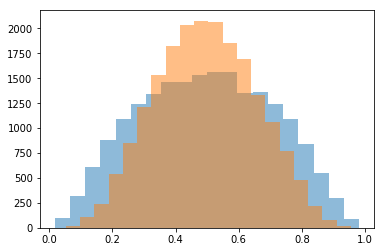

In [56]:
batch_images, batch_labels = mnist.train.next_batch(100)

feed_dict = {
    x: batch_images,
    target: batch_labels
}
result = session.run([hidden1, hidden2], feed_dict=feed_dict)
plt.hist(result[0].flatten(), 20, alpha=0.5)
plt.hist(result[1].flatten(), 20, alpha=0.5)

Ok, so even though the activations of the first layer aren't great, they are acceptable (they are centered around 0.5, and we don't have skipes at 0 and 1). Vanishing and exploding gradients are a very real problem when working with larger networks, such as feed-forward networks with many layers, or recurrent neural networks, so here we are safe from that.

Let's make a simple bit of magic. Try and substitute the tf.nn.sigmoid activation for tf.tanh and run again. 

In [57]:
tf.reset_default_graph()

def negloglikelihood_cost(out, target_out):
    return -tf.reduce_sum(target_out * tf.log(out + 1e-7), axis=1)

def accuracy(out, target_out):
    fraction = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out, axis=1), tf.argmax(target_out, axis=1)), tf.float32))
    return fraction * 100

def fully_connected(inp, size, activation_fn, scope):
    with tf.variable_scope(scope):
        weights = tf.get_variable("w", [inp.get_shape()[1], size])
        bias = tf.get_variable("b", [size], initializer=tf.zeros_initializer())
    return activation_fn(tf.matmul(inp, weights) + bias)

x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
hidden1 = fully_connected(x, 200, tf.tanh, scope="hidden1")
hidden2 = fully_connected(hidden1, 200, tf.tanh, scope="hidden2")
y = fully_connected(hidden2, 10, tf.nn.softmax, scope="y")

target = tf.placeholder(tf.float32, shape=[None, 10], name="target")

cost = tf.reduce_mean(negloglikelihood_cost(y, target))
acc = accuracy(y, target)
gradients = tf.gradients(cost, tf.trainable_variables())

update_op = tf.group(*[tf.assign(var, var - 0.01 * grad) for var, grad in zip(tf.trainable_variables(), gradients)])
init_op = tf.global_variables_initializer()

session = tf.Session()
session.run(init_op)

In [58]:
for i in range(10000):
    batch_images, batch_labels = mnist.train.next_batch(100)
    
    feed_dict = {
        x: batch_images,
        target: batch_labels
    }
    result = session.run([cost, acc, gradients, update_op], feed_dict=feed_dict)
    
    if i % 100 == 0:
        print("iter: {}, cost = {:.4f}, acc = {:.2f}%".format(i, result[0], result[1]))

iter: 0, cost = 2.4117, acc = 15.00%
iter: 100, cost = 1.0282, acc = 81.00%
iter: 200, cost = 0.7695, acc = 79.00%
iter: 300, cost = 0.6750, acc = 85.00%
iter: 400, cost = 0.6202, acc = 87.00%
iter: 500, cost = 0.6187, acc = 86.00%
iter: 600, cost = 0.4851, acc = 85.00%
iter: 700, cost = 0.4598, acc = 89.00%
iter: 800, cost = 0.4613, acc = 88.00%
iter: 900, cost = 0.4613, acc = 85.00%
iter: 1000, cost = 0.4459, acc = 91.00%
iter: 1100, cost = 0.3401, acc = 91.00%
iter: 1200, cost = 0.3826, acc = 89.00%
iter: 1300, cost = 0.3422, acc = 92.00%
iter: 1400, cost = 0.3259, acc = 92.00%
iter: 1500, cost = 0.1871, acc = 96.00%
iter: 1600, cost = 0.2820, acc = 93.00%
iter: 1700, cost = 0.3554, acc = 92.00%
iter: 1800, cost = 0.2835, acc = 90.00%
iter: 1900, cost = 0.2214, acc = 94.00%
iter: 2000, cost = 0.3025, acc = 91.00%
iter: 2100, cost = 0.2139, acc = 96.00%
iter: 2200, cost = 0.3081, acc = 90.00%
iter: 2300, cost = 0.3897, acc = 87.00%
iter: 2400, cost = 0.3343, acc = 90.00%
iter: 2500, 

In [59]:
feed_dict = {
    x: mnist.test.images,
    target: mnist.test.labels
}
result = session.run([cost, acc], feed_dict)
print("cost = {:.4f}, acc = {:.2f}%".format(result[0], result[1])) 

cost = 0.2052, acc = 94.12%


Ok, much better now, we are at 94% accuracy! I'll have you know, that that is really bad. State-of-the-art models can get as much as 99.7%. 

One thing that has a HUGE impact on the neural network's performance and that I haven't talked abou yet is the optimizaiton algorithm we use. Right now we are using a simple stochastic gradient descent, but that is just the simplest possible model we can use. __overview of optimizers__
__show animations in https://medium.com/towards-data-science/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f __

Let's start by changing our code in order to make use of Tensorflow's built-in optimizers, so we can get rid of this nasty tf.group thing.

In [60]:
tf.reset_default_graph()

def negloglikelihood_cost(out, target_out):
    return -tf.reduce_sum(target_out * tf.log(out + 1e-7), axis=1)

def accuracy(out, target_out):
    fraction = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out, axis=1), tf.argmax(target_out, axis=1)), tf.float32))
    return fraction * 100

def fully_connected(inp, size, activation_fn, scope):
    with tf.variable_scope(scope):
        weights = tf.get_variable("w", [inp.get_shape()[1], size])
        bias = tf.get_variable("b", [size], initializer=tf.zeros_initializer())
    return activation_fn(tf.matmul(inp, weights) + bias)

x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
hidden1 = fully_connected(x, 200, tf.tanh, scope="hidden1")
hidden2 = fully_connected(hidden1, 200, tf.tanh, scope="hidden2")
y = fully_connected(hidden2, 10, tf.nn.softmax, scope="y")

target = tf.placeholder(tf.float32, shape=[None, 10], name="target")

cost = tf.reduce_mean(negloglikelihood_cost(y, target))
acc = accuracy(y, target)

update_op = tf.train.GradientDescentOptimizer(0.01).minimize(cost)
init_op = tf.global_variables_initializer()

session = tf.Session()
session.run(init_op)

Now implement MomentumOptimizer and try some values of momentum to see how that affects learning.

Now let's use the optimizer that is the most widely use right now, AdamOptimizer.

__The setting below yields 100% training acc.__

In [127]:
tf.reset_default_graph()

def negloglikelihood_cost(out, target_out):
    return -tf.reduce_sum(target_out * tf.log(out + 1e-7), axis=1)

def accuracy(out, target_out):
    fraction = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out, axis=1), tf.argmax(target_out, axis=1)), tf.float32))
    return fraction * 100

def fully_connected(inp, size, activation_fn, scope):
    with tf.variable_scope(scope):
        weights = tf.get_variable("w", [inp.get_shape()[1], size])
        bias = tf.get_variable("b", [size], initializer=tf.zeros_initializer())
    return activation_fn(tf.matmul(inp, weights) + bias)

x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
hidden1 = fully_connected(x, 200, tf.tanh, scope="hidden1")
hidden2 = fully_connected(hidden1, 200, tf.tanh, scope="hidden2")
y = fully_connected(hidden2, 10, tf.nn.softmax, scope="y")

target = tf.placeholder(tf.float32, shape=[None, 10], name="target")

cost = tf.reduce_mean(negloglikelihood_cost(y, target))
acc = accuracy(y, target)

update_op = tf.train.AdamOptimizer(0.001).minimize(cost)
init_op = tf.global_variables_initializer()

session = tf.Session()
session.run(init_op)

In [128]:
for i in range(10000):
    batch_x, batch_y = mnist.train.next_batch(100)
    
    feed_dict = {
        x: batch_x,
        target: batch_y
    }
    result = session.run([cost, acc, update_op], feed_dict=feed_dict)
    
    if i % 100 == 0:
        print("iter: {}, cost = {:.4f}, acc = {:.2f}%".format(i, result[0], result[1]))

iter: 0, cost = 2.4534, acc = 7.00%
iter: 100, cost = 0.3412, acc = 88.00%
iter: 200, cost = 0.2671, acc = 91.00%
iter: 300, cost = 0.2192, acc = 93.00%
iter: 400, cost = 0.2166, acc = 94.00%
iter: 500, cost = 0.1794, acc = 93.00%
iter: 600, cost = 0.2248, acc = 95.00%
iter: 700, cost = 0.3159, acc = 90.00%
iter: 800, cost = 0.2142, acc = 95.00%
iter: 900, cost = 0.2031, acc = 94.00%
iter: 1000, cost = 0.2748, acc = 89.00%
iter: 1100, cost = 0.1922, acc = 97.00%
iter: 1200, cost = 0.1222, acc = 99.00%
iter: 1300, cost = 0.1254, acc = 96.00%
iter: 1400, cost = 0.0735, acc = 98.00%
iter: 1500, cost = 0.0711, acc = 99.00%
iter: 1600, cost = 0.2662, acc = 97.00%
iter: 1700, cost = 0.1127, acc = 95.00%
iter: 1800, cost = 0.0699, acc = 100.00%
iter: 1900, cost = 0.0424, acc = 99.00%
iter: 2000, cost = 0.0812, acc = 98.00%
iter: 2100, cost = 0.1705, acc = 94.00%
iter: 2200, cost = 0.0844, acc = 96.00%
iter: 2300, cost = 0.0877, acc = 95.00%
iter: 2400, cost = 0.0181, acc = 100.00%
iter: 2500,

In [129]:
feed_dict = {
    x: mnist.test.images,
    target: mnist.test.labels
}
result = session.run([cost, acc], feed_dict)
print("iter: {}, cost = {:.4f}, acc = {:.2f}%".format(i, result[0], result[1])) 

iter: 9999, cost = 0.0747, acc = 97.89%


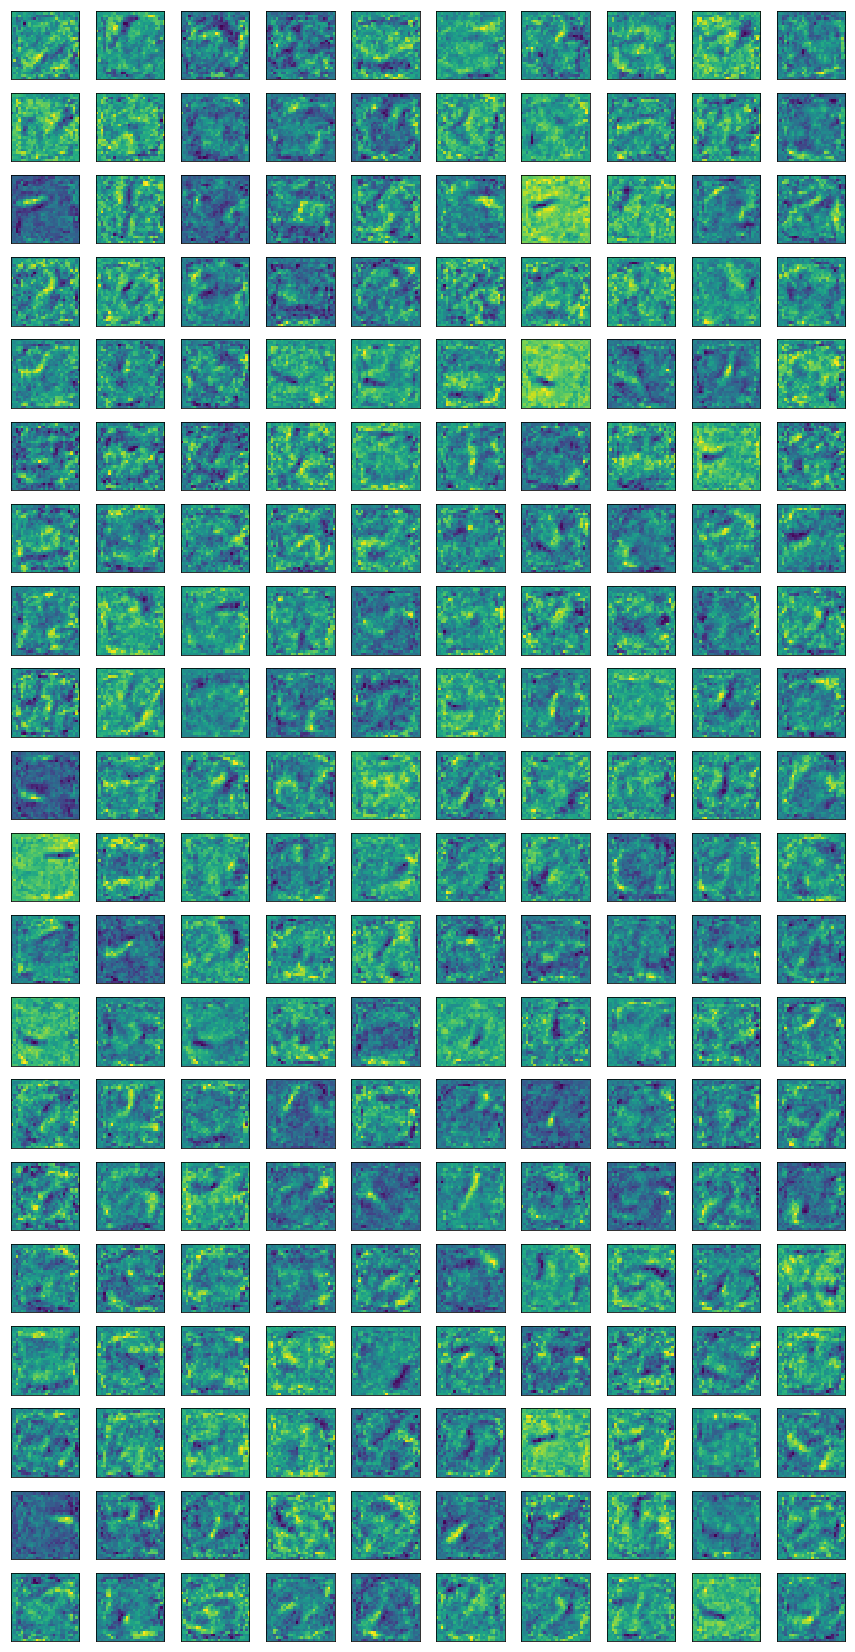

In [136]:
import matplotlib.gridspec as gridspec

fig = plt.figure(1, figsize=(10*1.5, 20*1.5))
gs1 = gridspec.GridSpec(20, 10)

w = [var for var in tf.trainable_variables() if "w:0" in var.name][0]
w = session.run(w)

for i in range(20):
    for j in range(10):
        ax1 = fig.add_subplot(gs1[i, j])
        ax1.imshow(w[:,i*10+j].reshape(28,28))

for ax in fig.get_axes():
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_ticks([])

Ok, now we are getting somewhere: 100% training accuracy and 98.17% test accuracy!
Still, it is a bit unsettling that our test error is quite a bit bigger than our training error, whihc are at 0.074 and <0.01 respectively.
When this happens, we say that our network is overfitting (although not too much - the bigger the difference between training and test erro, the bigger the overfitting). __make the usual 5th degree polynomial plot to show this and describe regularization__

So let's try to implement L2 regularization.

In [106]:
tf.reset_default_graph()

def negloglikelihood_cost(out, target_out):
    return -tf.reduce_sum(target_out * tf.log(out + 1e-7), axis=1)

def accuracy(out, target_out):
    fraction = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out, axis=1), tf.argmax(target_out, axis=1)), tf.float32))
    return fraction * 100

def fully_connected(inp, size, activation_fn, scope):
    with tf.variable_scope(scope):
        weights = tf.get_variable("w", [inp.get_shape()[1], size])
        bias = tf.get_variable("b", [size], initializer=tf.zeros_initializer())
    return activation_fn(tf.matmul(inp, weights) + bias)

training_mode = tf.placeholder(tf.bool, shape=[], name="training_mode")

x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
hidden1 = fully_connected(x, 500, tf.tanh, scope="hidden1")
do1 = tf.layers.dropout(hidden1, rate=0.3, training=training_mode, name="do1")
hidden2 = fully_connected(do1, 500, tf.tanh, scope="hidden2")
do2 = tf.layers.dropout(hidden2, rate=0.3, training=training_mode, name="do2")
hidden3 = fully_connected(do2, 200, tf.tanh, scope="hidden3")
do3 = tf.layers.dropout(hidden3, rate=0.3, training=training_mode, name="do3")
y = fully_connected(do3, 10, tf.nn.softmax, scope="y")

target = tf.placeholder(tf.float32, shape=[None, 10], name="target")

all_weights = [var for var in tf.trainable_variables() if "w:" in var.name] 

cost = tf.reduce_mean(negloglikelihood_cost(y, target)) #+ 0.0005*tf.add_n([tf.nn.l2_loss(var) for var in all_weights])
acc = accuracy(y, target)

update_op = tf.train.AdamOptimizer(0.0005).minimize(cost)
init_op = tf.global_variables_initializer()

session = tf.Session()
session.run(init_op)

In [107]:
for i in range(20000):
    batch_x, batch_y = mnist.train.next_batch(100)
    
    feed_dict = {
        x: batch_x,
        target: batch_y,
        training_mode: True
    }
    result = session.run([cost, acc, update_op], feed_dict=feed_dict)
    
    if i % 100 == 0:
        print("iter: {}, cost = {:.4f}, acc = {:.2f}%".format(i, result[0], result[1]))

iter: 0, cost = 2.5044, acc = 13.00%
iter: 100, cost = 0.2438, acc = 91.00%
iter: 200, cost = 0.3025, acc = 89.00%
iter: 300, cost = 0.2953, acc = 89.00%
iter: 400, cost = 0.3246, acc = 94.00%
iter: 500, cost = 0.2640, acc = 92.00%
iter: 600, cost = 0.3530, acc = 88.00%
iter: 700, cost = 0.2550, acc = 90.00%
iter: 800, cost = 0.2543, acc = 91.00%
iter: 900, cost = 0.2347, acc = 93.00%
iter: 1000, cost = 0.1396, acc = 96.00%
iter: 1100, cost = 0.3017, acc = 89.00%
iter: 1200, cost = 0.2016, acc = 95.00%
iter: 1300, cost = 0.1829, acc = 93.00%
iter: 1400, cost = 0.1316, acc = 95.00%
iter: 1500, cost = 0.2784, acc = 94.00%
iter: 1600, cost = 0.1867, acc = 94.00%
iter: 1700, cost = 0.1761, acc = 96.00%
iter: 1800, cost = 0.1368, acc = 96.00%
iter: 1900, cost = 0.1411, acc = 95.00%
iter: 2000, cost = 0.1687, acc = 91.00%
iter: 2100, cost = 0.1127, acc = 96.00%
iter: 2200, cost = 0.1536, acc = 94.00%
iter: 2300, cost = 0.0994, acc = 97.00%
iter: 2400, cost = 0.2373, acc = 93.00%
iter: 2500, 

In [109]:
feed_dict = {
    x: mnist.test.images,
    target: mnist.test.labels,
    training_mode: False
}
result = session.run([cost, acc], feed_dict)
print("iter: {}, cost = {:.4f}, acc = {:.2f}%".format(i, result[0], result[1])) 

iter: 19999, cost = 0.0751, acc = 98.15%


So, we have kinda peaked in our neural network performance. Stacking more layers or making them wider won't make that much of a difference. But I told you it is easy to get over 99% test accuracy, so at this point we need some new tricks. __mention eg data augmentation__
But the most important difference is changing the structure of our network __introduce convolutions__